# F. Analyse sentiment by sentence
## Import necessary libraries

In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [6]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [7]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.

if IN_COLAB:
    !pip install numpy==1.19.4
    !pip install pandas==1.1.4
    !pip install torch==1.7.0
    !pip install tqdm==4.51.0
    !pip install scikit-plot==0.3.7
    !pip install transformers==3.5.0

In [9]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
os.environ['SSL_CERT_FILE'] = "/Users/ethancui/anaconda3/lib/python3.11/site-packages/certifi/cacert.pem"
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ethancui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ethancui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ethancui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [11]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [12]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [13]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load and process input data

In [14]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [15]:
if IN_COLAB:
    preprocessed_dir = 'drive/My Drive/Colab Data/'
    train_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
    model_dir = 'drive/My Drive/Colab Data/'
else:
    preprocessed_dir = '../data/preprocessed/'
    train_dir = '../data/train_data/'
    output_dir = '../data/result/'
    lmdict_dir = '../data/LoughranMcDonald/'
    glove_dir = '../data/GloVe'
    model_dir = '../data/models/'

Check the texts which is filtered by keyword as well

In [16]:
# Load text data
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


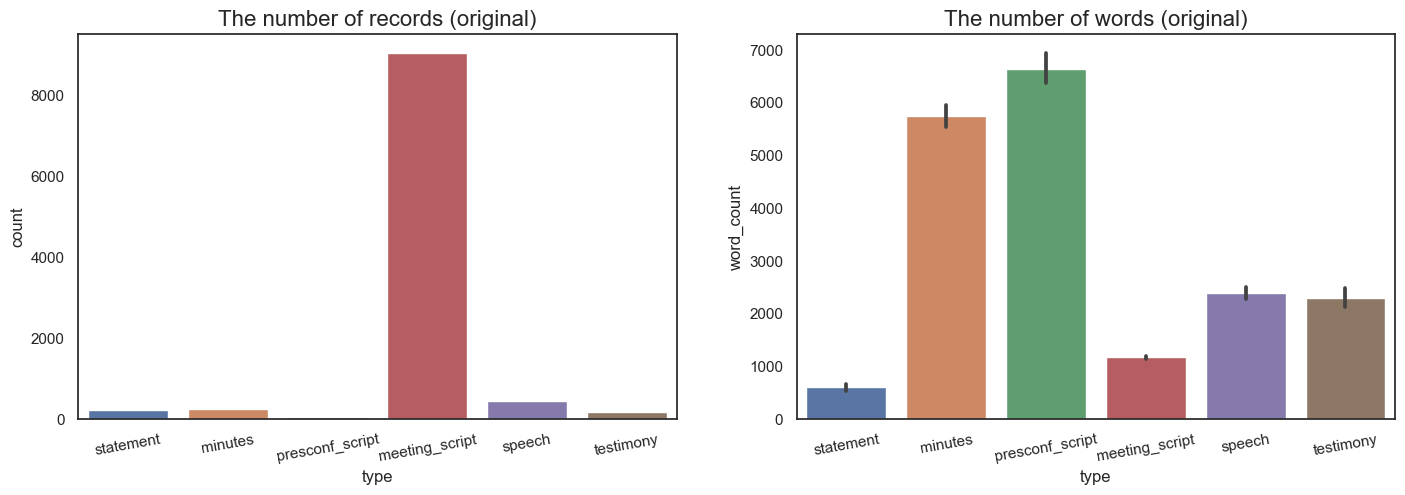

In [17]:
# Check the number of records per document type
def plot_num_rec_word(df):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)
    
# All texts
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.5,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


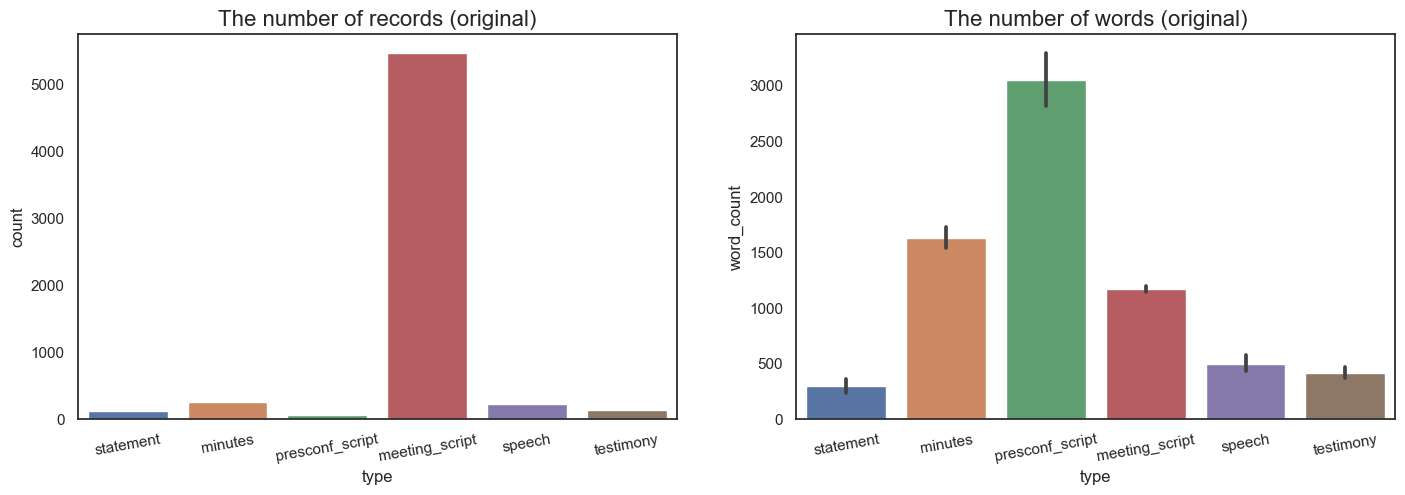

In [18]:
# Filtered by keywords
plot_num_rec_word(text_keyword)
text_keyword.head()

In [19]:
# Drop meeting script data since it is too long
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
#text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe
Here, use all the texts but keywords filtere one would give better performance - to be checked.

In [20]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row
            
    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

(1178, 11)


IndexError: Too many levels: Index has only 1 level, not 2

In [21]:
train_df = text_no_split # without meeting script

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: boolean value of NA is ambiguous

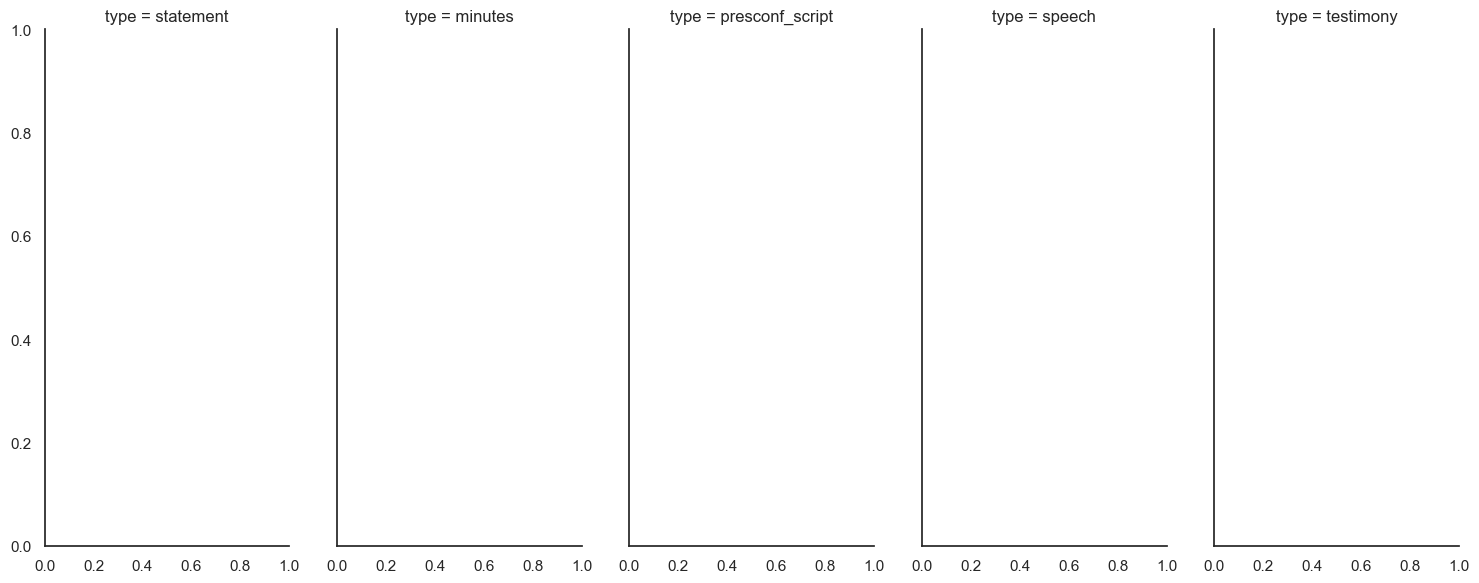

In [22]:
# Check balance of Rate Decision
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/4191536359.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/4191536359.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147e

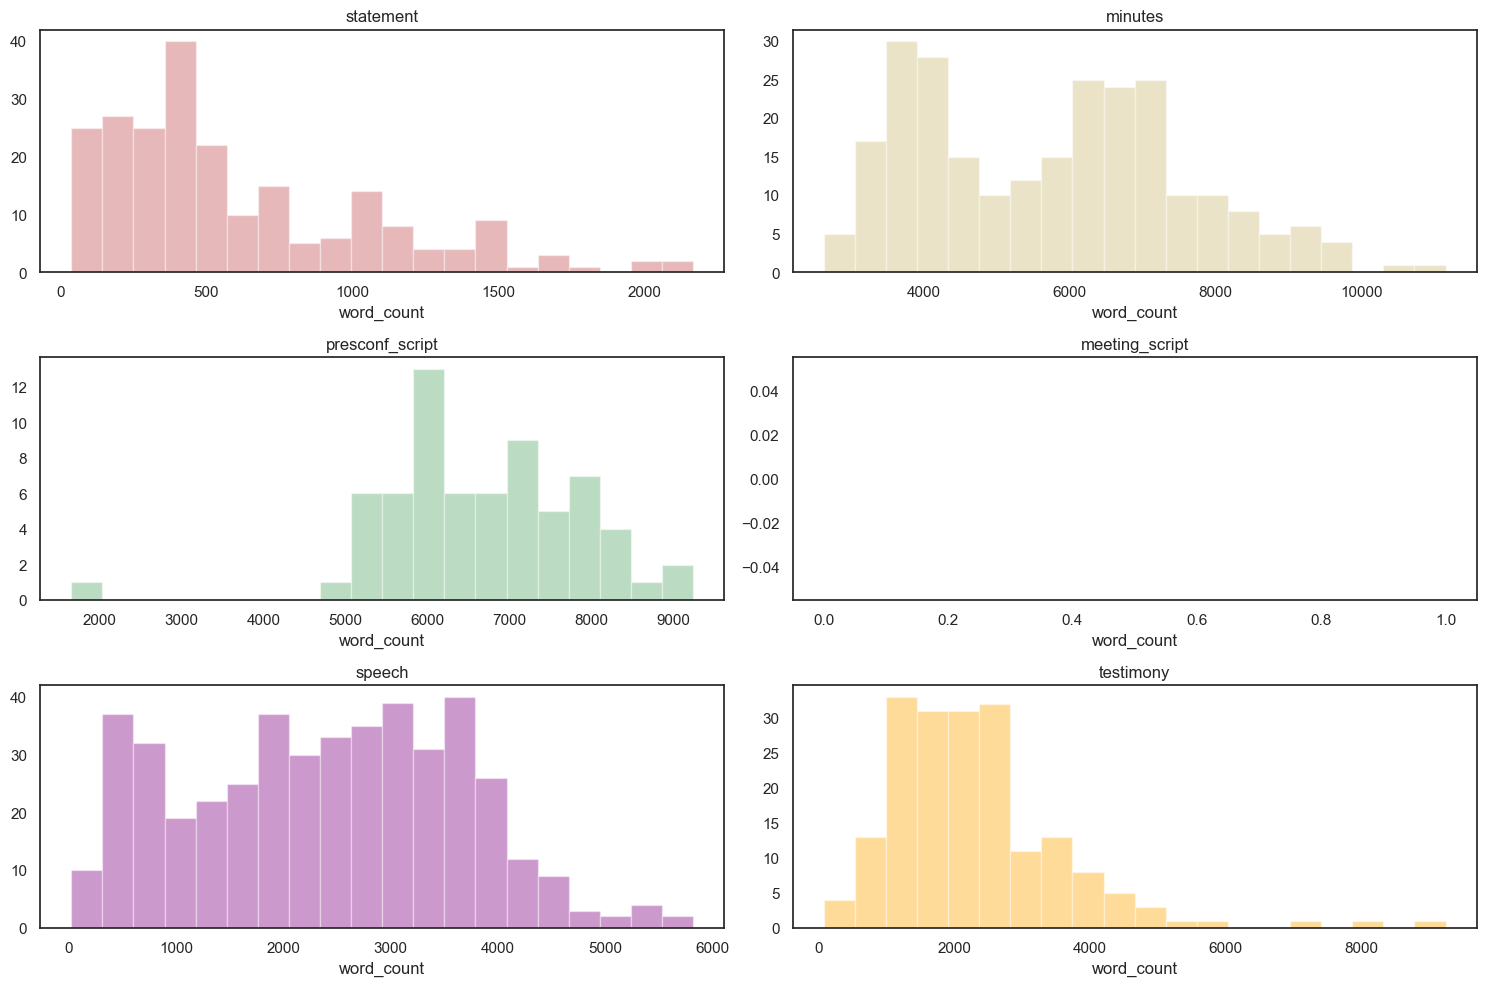

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
10232,testimony,2022-01-11,Nomination hearing,Jerome Powell,654,<NA>,None,2022-01-26,0,0.00,"Chairman Brown, Ranking Member Toomey, and oth..."
10233,testimony,2022-03-02,Semiannual Monetary Policy Report to the Congress,Jerome Powell,801,<NA>,None,2022-03-16,1,0.25,"At the Federal Reserve, we are strongly commit..."
10234,testimony,2022-06-22,Semiannual Monetary Policy Report to the Congress,Jerome Powell,864,<NA>,None,2022-07-27,1,2.25,I will begin with one overarching message. At ...
10235,testimony,2023-03-07,Semiannual Monetary Policy Report to the Congress,Jerome Powell,931,<NA>,None,2023-03-22,1,4.75,My colleagues and I are acutely aware that hig...
10236,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,856,<NA>,None,NaT,<NA>,NaN,We at the Fed remain squarely focused on our d...


In [23]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


In [24]:
# Add a key for aggregation
train_df['key'] = train_df.index.get_level_values(0)
train_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,1
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,2
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",3
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",4


In [25]:
# 30*8*5

## Split each text by sentence

In [26]:
# Split the data by sentence
def split_df(df, text_column='text'):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

train_sent_df = split_df(train_df)
print(train_sent_df.shape)

  0%|          | 0/1178 [00:00<?, ?it/s]

(130128, 12)


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/4191536359.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/4191536359.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147e

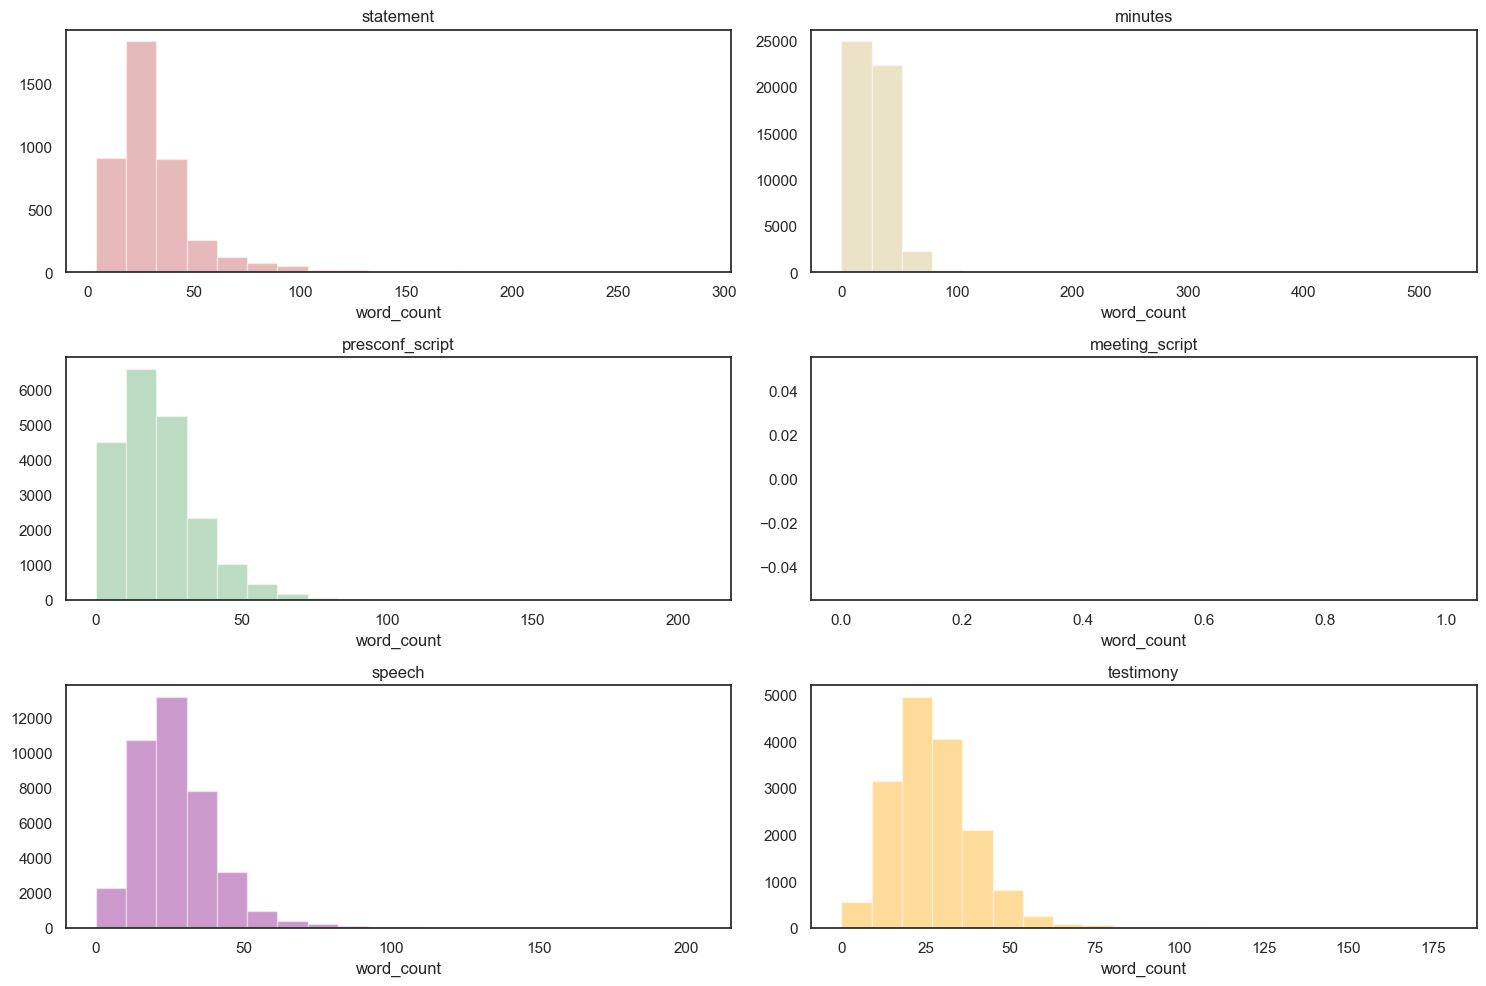

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
130123,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,12,<NA>,NaN,NaT,<NA>,NaN,"Before concluding, let me briefly address the ...",10236
130124,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,9,<NA>,NaN,NaT,<NA>,NaN,The U.S. banking system is sound and resilient.,10236
130125,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,48,<NA>,NaN,NaT,<NA>,NaN,As detailed in the box on financial stability ...,10236
130126,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,35,<NA>,NaN,NaT,<NA>,NaN,"The recent bank failures, including the failur...",10236
130127,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,17,<NA>,NaN,NaT,<NA>,NaN,We are committed to addressing these vulnerabi...,10236


In [27]:
# Check distribution
plot_distribution(train_sent_df, False)
train_sent_df.tail()

## Load a trained model

In [28]:
import transformers
import torch

print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)


PyTorch version: 2.0.1
Transformers version: 4.31.0


In [29]:
# Load a BERT model, which was trained by another Financial Texts
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(model_dir + 'finphrase_bert_trained.dict', map_location=torch.device('cpu')))
model.eval()
model.to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Predict sentiment for every sentence
### Define Encoder, Model and Prediction functions

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [31]:
def predict(text, model):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        pred : Prediction vector
    """        
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = F.softmax(outputs, dim=1).cpu().numpy()
    
    return pred

In [32]:
# Check
text = "Google is working on self driving cars, I'm positive on $goog" # bad, neutral, good
predict(text, model)

array([[3.2405715e-04, 1.2590579e-04, 9.9955004e-01]], dtype=float32)

In [33]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts
    
    return df



### Run Prediction

In [34]:
doc_types = train_sent_df['type'].unique().tolist()
doc_types

['statement', 'minutes', 'presconf_script', 'speech', 'testimony']

In [35]:
result_df = pd.DataFrame([], columns=train_df.columns)
for doc_type in doc_types:
    print('Processing {}...'.format(doc_type))
    train_sample = train_sent_df.loc[(train_sent_df['type']==doc_type)]
    res = score_text(train_sample, 'text', model)
    result_df = pd.concat([result_df, res], axis=0)

result_df.head()

Processing statement...


  0%|          | 0/4236 [00:00<?, ?it/s]

Processing minutes...


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = scores
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = predicts


  0%|          | 0/50030 [00:00<?, ?it/s]

Processing presconf_script...


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = scores
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = predicts


  0%|          | 0/20500 [00:00<?, ?it/s]

Processing speech...


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = scores
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = predicts


  0%|          | 0/39233 [00:00<?, ?it/s]

Processing testimony...


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = scores
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = predicts


  0%|          | 0/16129 [00:00<?, ?it/s]

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = scores
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4852/1948379108.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = predicts


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,score,prediction
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,22,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0,"[8.023522e-05, 0.9990847, 0.0008350057]",Neutral
1,statement,1994-02-04,FOMC Statement,Alan Greenspan,18,1,3.25,1994-02-28,0,3.25,The action is expected to be associated with a...,0,"[0.00037612257, 0.00024042556, 0.99938345]",Positive
2,statement,1994-02-04,FOMC Statement,Alan Greenspan,23,1,3.25,1994-02-28,0,3.25,The decision was taken to move toward a less a...,0,"[0.00012560187, 0.9947305, 0.005143919]",Neutral
3,statement,1994-02-04,FOMC Statement,Alan Greenspan,36,1,3.25,1994-02-28,0,3.25,Chairman Greenspan decided to announce this ac...,0,"[5.66113e-05, 0.99985385, 8.954839e-05]",Neutral
4,statement,1994-03-22,FOMC Statement,Alan Greenspan,22,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,1,"[8.023522e-05, 0.9990847, 0.0008350057]",Neutral


In [36]:
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)
result_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,score,prediction,Negative,Neutral,Positive
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,22,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0,"[8.023522e-05, 0.9990847, 0.0008350057]",Neutral,False,True,False
1,statement,1994-02-04,FOMC Statement,Alan Greenspan,18,1,3.25,1994-02-28,0,3.25,The action is expected to be associated with a...,0,"[0.00037612257, 0.00024042556, 0.99938345]",Positive,False,False,True
2,statement,1994-02-04,FOMC Statement,Alan Greenspan,23,1,3.25,1994-02-28,0,3.25,The decision was taken to move toward a less a...,0,"[0.00012560187, 0.9947305, 0.005143919]",Neutral,False,True,False
3,statement,1994-02-04,FOMC Statement,Alan Greenspan,36,1,3.25,1994-02-28,0,3.25,Chairman Greenspan decided to announce this ac...,0,"[5.66113e-05, 0.99985385, 8.954839e-05]",Neutral,False,True,False
4,statement,1994-03-22,FOMC Statement,Alan Greenspan,22,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,1,"[8.023522e-05, 0.9990847, 0.0008350057]",Neutral,False,True,False


In [37]:
result_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,score,prediction,Negative,Neutral,Positive
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,22,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0,"[8.023522e-05, 0.9990847, 0.0008350057]",Neutral,False,True,False
1,statement,1994-02-04,FOMC Statement,Alan Greenspan,18,1,3.25,1994-02-28,0,3.25,The action is expected to be associated with a...,0,"[0.00037612257, 0.00024042556, 0.99938345]",Positive,False,False,True
2,statement,1994-02-04,FOMC Statement,Alan Greenspan,23,1,3.25,1994-02-28,0,3.25,The decision was taken to move toward a less a...,0,"[0.00012560187, 0.9947305, 0.005143919]",Neutral,False,True,False
3,statement,1994-02-04,FOMC Statement,Alan Greenspan,36,1,3.25,1994-02-28,0,3.25,Chairman Greenspan decided to announce this ac...,0,"[5.66113e-05, 0.99985385, 8.954839e-05]",Neutral,False,True,False
4,statement,1994-03-22,FOMC Statement,Alan Greenspan,22,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,1,"[8.023522e-05, 0.9990847, 0.0008350057]",Neutral,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130123,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,12,<NA>,NaN,NaT,<NA>,NaN,"Before concluding, let me briefly address the ...",10236,"[5.034953e-05, 0.99988294, 6.673639e-05]",Neutral,False,True,False
130124,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,9,<NA>,NaN,NaT,<NA>,NaN,The U.S. banking system is sound and resilient.,10236,"[4.2987904e-05, 0.9998735, 8.343299e-05]",Neutral,False,True,False
130125,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,48,<NA>,NaN,NaT,<NA>,NaN,As detailed in the box on financial stability ...,10236,"[5.5903678e-05, 0.99957496, 0.00036920575]",Neutral,False,True,False
130126,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,35,<NA>,NaN,NaT,<NA>,NaN,"The recent bank failures, including the failur...",10236,"[0.14073731, 0.8235141, 0.035748567]",Neutral,False,True,False


In [38]:
train_result = train_df.copy()
train_result['key2'] = train_result['type'] + "_" + train_result['key'].map(str)
result_df['key2'] = result_df['type'] + "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])
train_result.sort_values(['type', 'next_meeting'], inplace=True)

print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()

The number of records:  1178
Sentiment is null:  0


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,key2,Negative,Neutral,Positive,sentiment
1173,testimony,2022-01-11,Nomination hearing,Jerome Powell,654,<NA>,None,2022-01-26,0,0.00,"Chairman Brown, Ranking Member Toomey, and oth...",10232,testimony_10232,1,27,6,5
1174,testimony,2022-03-02,Semiannual Monetary Policy Report to the Congress,Jerome Powell,801,<NA>,None,2022-03-16,1,0.25,"At the Federal Reserve, we are strongly commit...",10233,testimony_10233,7,19,8,1
1175,testimony,2022-06-22,Semiannual Monetary Policy Report to the Congress,Jerome Powell,864,<NA>,None,2022-07-27,1,2.25,I will begin with one overarching message. At ...,10234,testimony_10234,11,15,13,2
1176,testimony,2023-03-07,Semiannual Monetary Policy Report to the Congress,Jerome Powell,931,<NA>,None,2023-03-22,1,4.75,My colleagues and I are acutely aware that hig...,10235,testimony_10235,13,17,10,-3
1177,testimony,2023-06-21,Semiannual Monetary Policy Report to the Congress,Jerome Powell,856,<NA>,None,NaT,<NA>,NaN,We at the Fed remain squarely focused on our d...,10236,testimony_10236,11,16,8,-3


In [39]:
# rewrite the function to get rid of value error of tuple
def get_doctype_df(df, doc_type):
    if doc_type == 'all':
        new_df = df
    else:
        new_df = df.loc[df['type'] == doc_type]

    # Convert the column selection from tuple to list
    new_df = new_df.groupby(by=['next_meeting', 'next_decision', 'next_rate'])[['Negative', 'Neutral', 'Positive', 'sentiment']].sum()
    new_df.reset_index(level=[1, 2], inplace=True)
    new_df.sort_index(inplace=True)
    new_df['next_rate_change'] = new_df['next_rate'] - new_df['next_rate'].shift(1)
    new_df['sentiment_pct'] = new_df['sentiment'] / (new_df['Positive'] + new_df['Negative'])
    new_df['sentiment_chg'] = new_df['sentiment'] - new_df['sentiment'].shift(1)
    return new_df


In [40]:
stmt_df = get_doctype_df(train_result, 'statement')
minutes_df = get_doctype_df(train_result, 'minutes')
presconf_df = get_doctype_df(train_result, 'presconf_script')
m_script_df = get_doctype_df(train_result, 'meeting_script')
speech_df = get_doctype_df(train_result, 'speech')
testimony_df = get_doctype_df(train_result, 'testimony')
all_df = get_doctype_df(pd.concat([stmt_df, minutes_df, presconf_df, m_script_df, speech_df, testimony_df], axis=0), 'all')
all_df

,next_decision,next_rate,Negative,Neutral,Positive,sentiment,next_rate_change,sentiment_pct,sentiment_chg
next_meeting,,,,,,,,,
1993-02-18,0,3.00,44,123,79,35,NaN,0.284553,NaN
1993-05-18,0,3.00,42,76,59,17,0.00,0.168317,-18.0
1993-07-07,0,3.00,42,67,47,5,0.00,0.056180,-12.0
1993-08-17,0,3.00,41,97,70,29,0.00,0.261261,24.0
1993-09-21,0,3.00,35,62,55,20,0.00,0.222222,-9.0
...,...,...,...,...,...,...,...,...,...
2022-12-14,1,4.25,114,385,169,55,0.50,0.194346,8.0
2023-02-01,1,4.50,120,354,131,11,0.25,0.043825,-44.0
2023-03-22,1,4.75,116,382,136,20,0.25,0.079365,9.0


In [41]:
# Show corelations to target
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    
def plot_sentiment(df, doc_type, sent_column):
    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
    sns.lineplot(y=df[sent_column], x=df.index.get_level_values(0), ax=ax1)
    #ax1.set_xlim('1992-01-01', '2020-06-01')
    ax1.set_ylabel('Sentiment: {}'.format(sent_column))
    ax1.set_xlabel('Year')
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] > 0, facecolor='blue', alpha=0.2)
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] < 0, facecolor='red', alpha=0.2)
    ax12 = ax1.twinx()
    sns.lineplot(y=df['next_rate'].fillna(0), x=df.index.get_level_values(0), ax=ax12, color='green')
    #ax12.yaxis.grid(True, which='major')
    ax12.set_ylim(-4,8)
    ax12.legend("Rate", loc='upper right')
    align_yaxis(ax1, 0, ax12, 0)
    #arrow_style = dict(facecolor='black', shrink=0.05)
    #ax12.annotate('QE1+', xy=('2009-03-18', -2), xytext=('2009-03-18', -3), size=12, ha='center', arrowprops=arrow_style)
    #ax12.annotate('QE1', xy=('2008-11-25', -2.5), xytext=('2008-11-25', -3.5), size=12, ha='right', arrowprops=arrow_style)
    #ax12.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -1), size=12, ha='center', arrowprops=arrow_style)
    #ax12.annotate('QE2+', xy=('2011-09-21', -2), xytext=('2011-09-21', -3), size=12, ha='center', arrowprops=arrow_style)
    #ax12.annotate('QE3', xy=('2012-09-13', -2), xytext=('2012-09-13', -3), size=12, ha='center', arrowprops=arrow_style)
    #ax12.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -2), size=12, ha='center', arrowprops=arrow_style)

    
    plt.title('Net sentiment over years with the next FED target rate', fontsize=16)

    corr_columns = ['sentiment', 'sentiment_pct', 'sentiment_chg', 'next_decision', 'next_rate_change', 'next_rate']
    sns.heatmap(df[corr_columns].astype(float).corr().iloc[:3], annot=True, fmt=".2f", ax=ax2, cmap= 'coolwarm', center=0, vmin=-1, vmax=1)
    ax2.set_title("Correlation", fontsize=16)
    
    plt.suptitle("Doc Type: {}".format(doc_type), fontsize=16)
    plt.show()


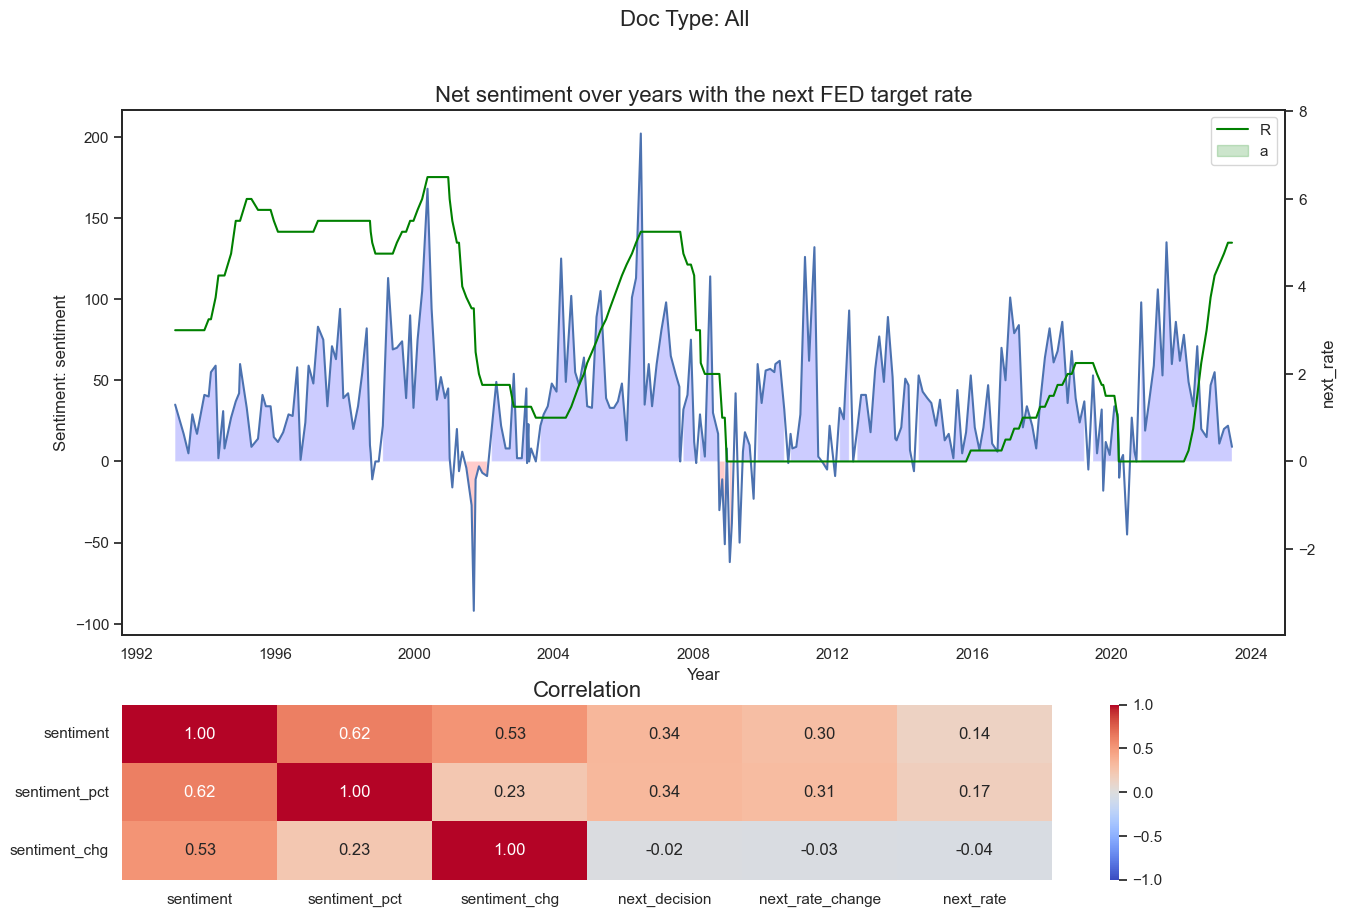

In [42]:
plot_sentiment(all_df, 'All', 'sentiment')




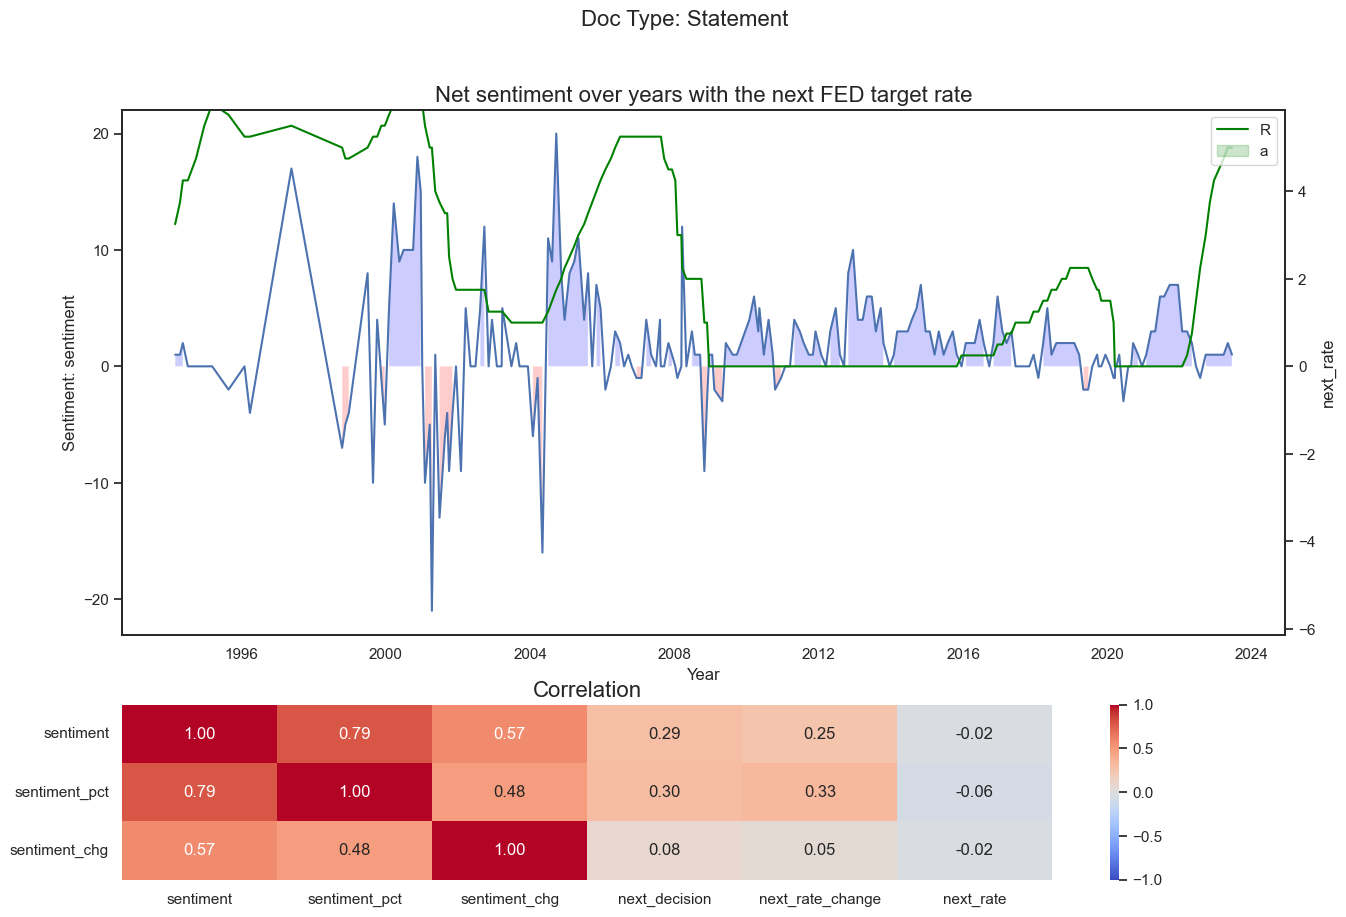

In [43]:
plot_sentiment(stmt_df, 'Statement', 'sentiment')

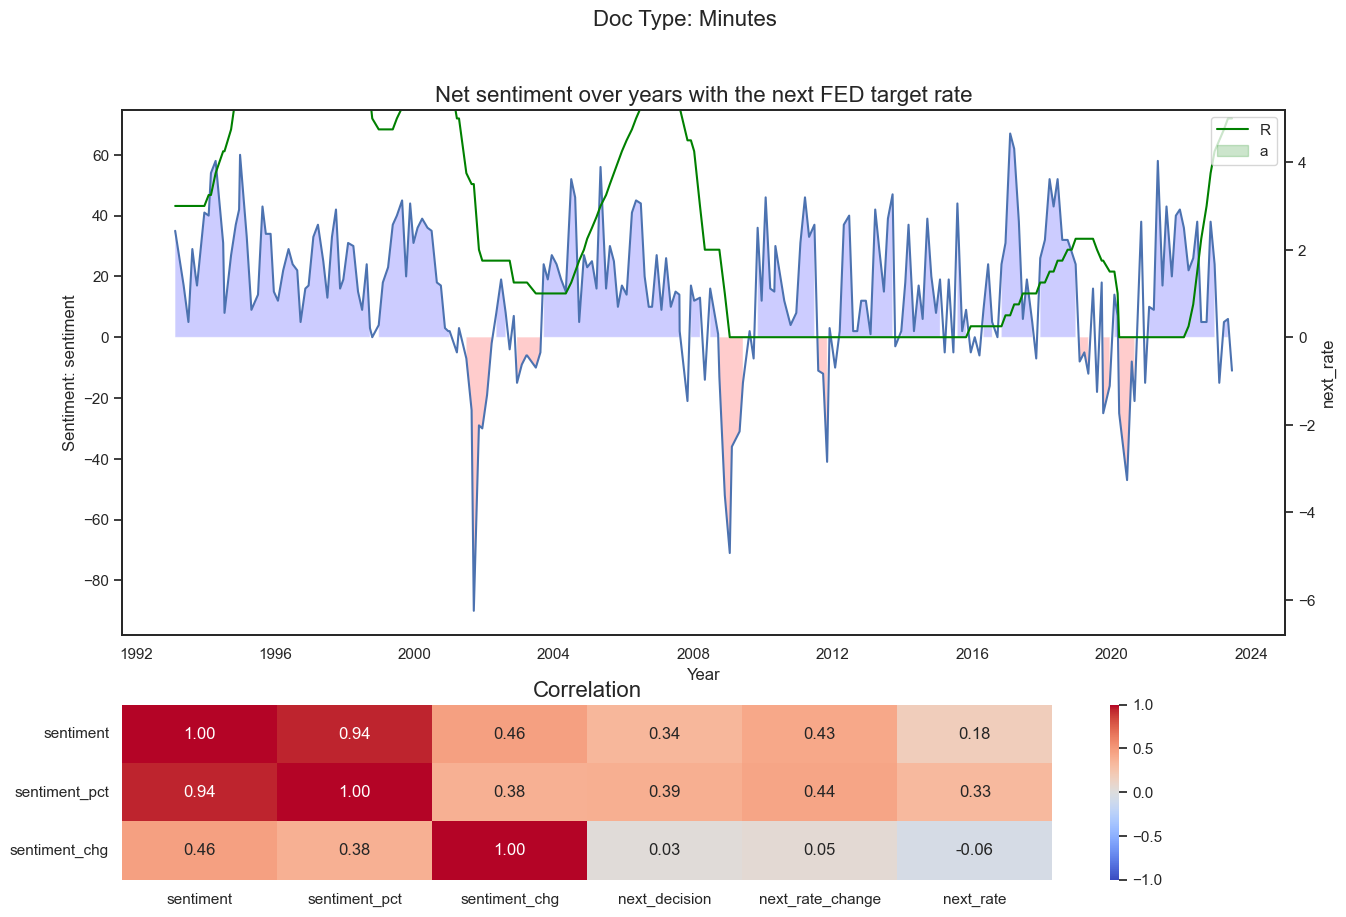

In [44]:
plot_sentiment(minutes_df, 'Minutes', 'sentiment')

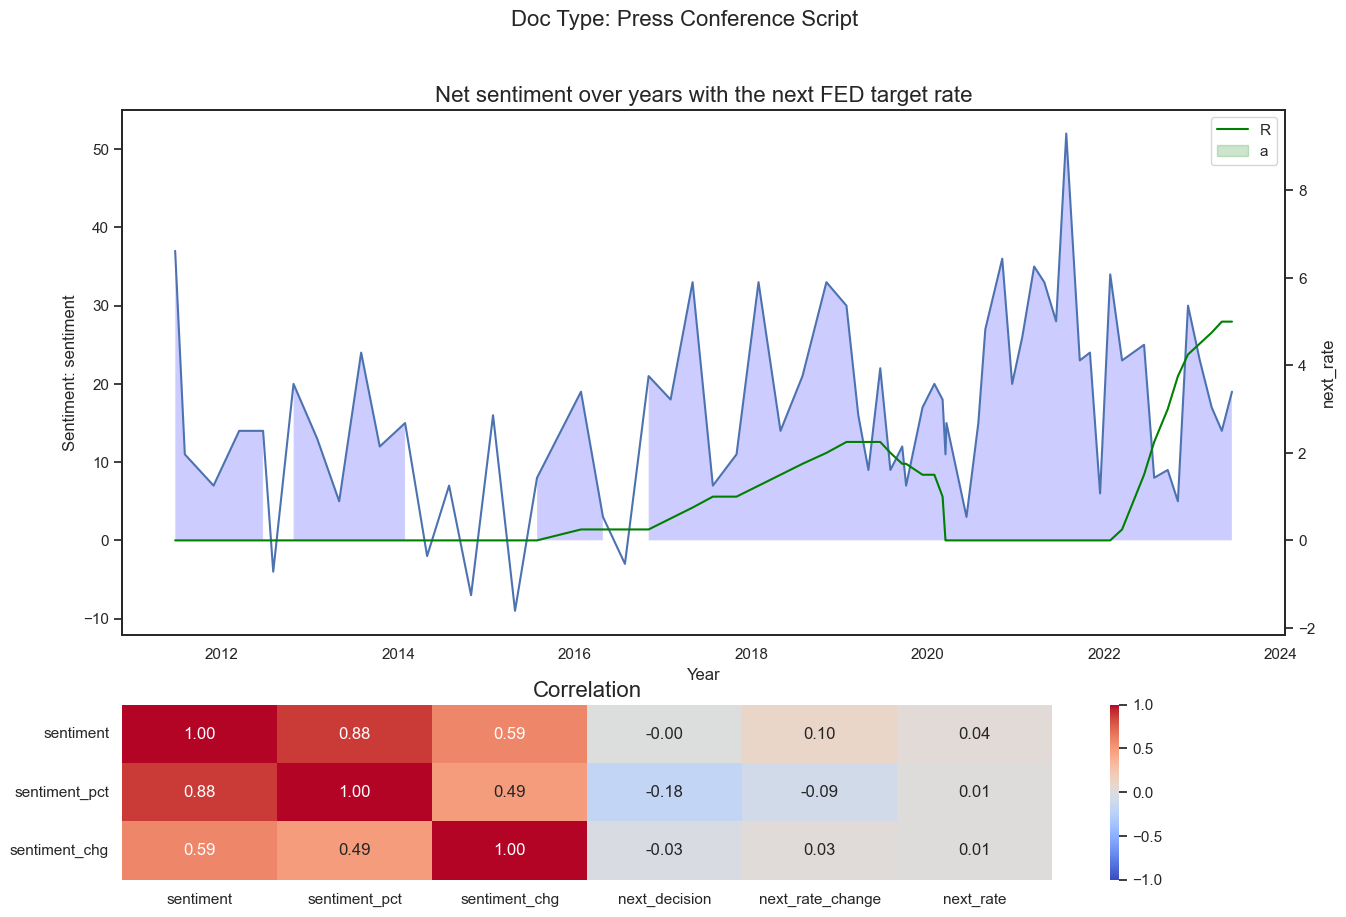

In [45]:
plot_sentiment(presconf_df, 'Press Conference Script', 'sentiment')

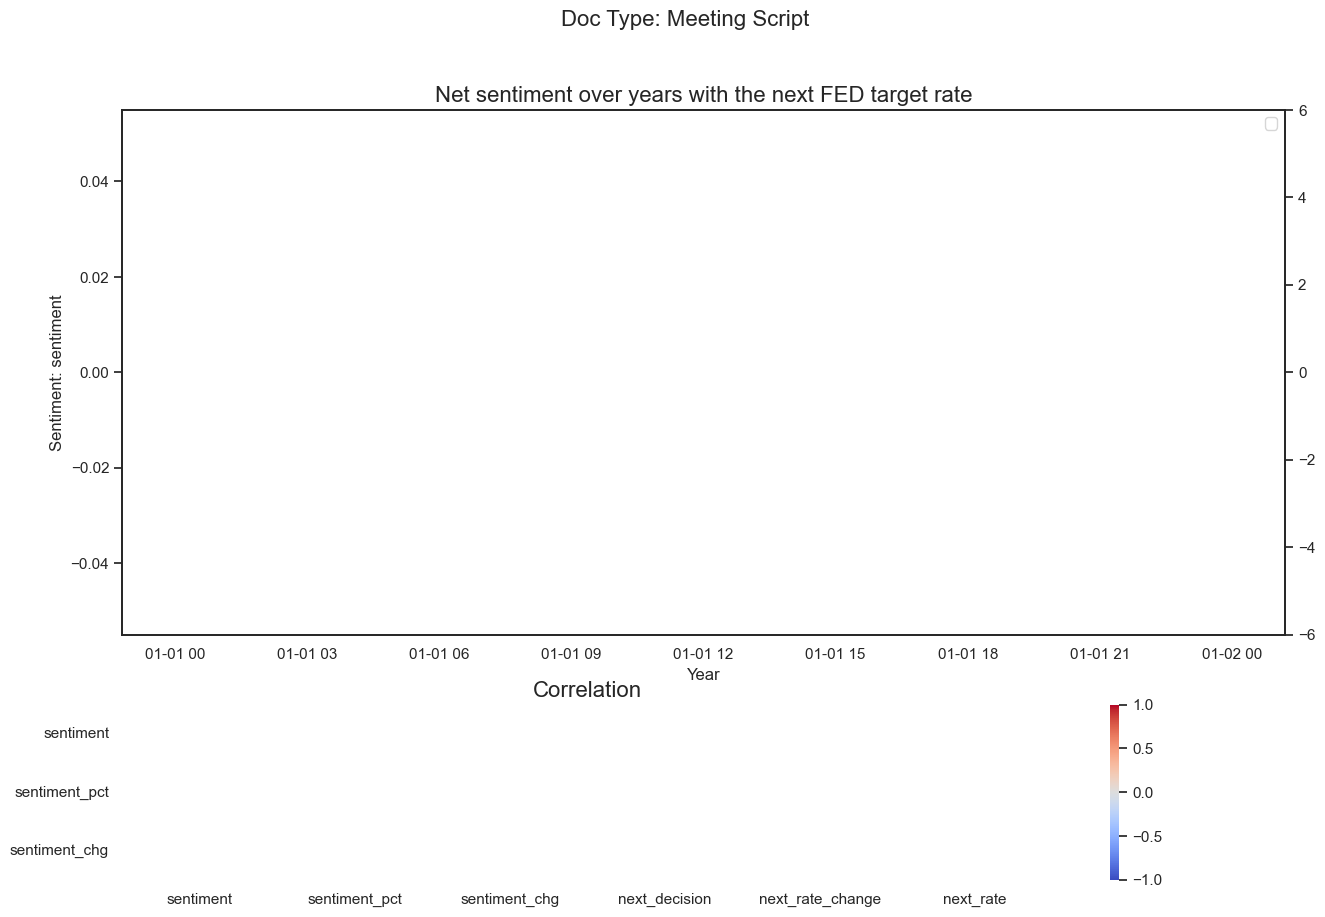

In [46]:
plot_sentiment(m_script_df, 'Meeting Script', 'sentiment')

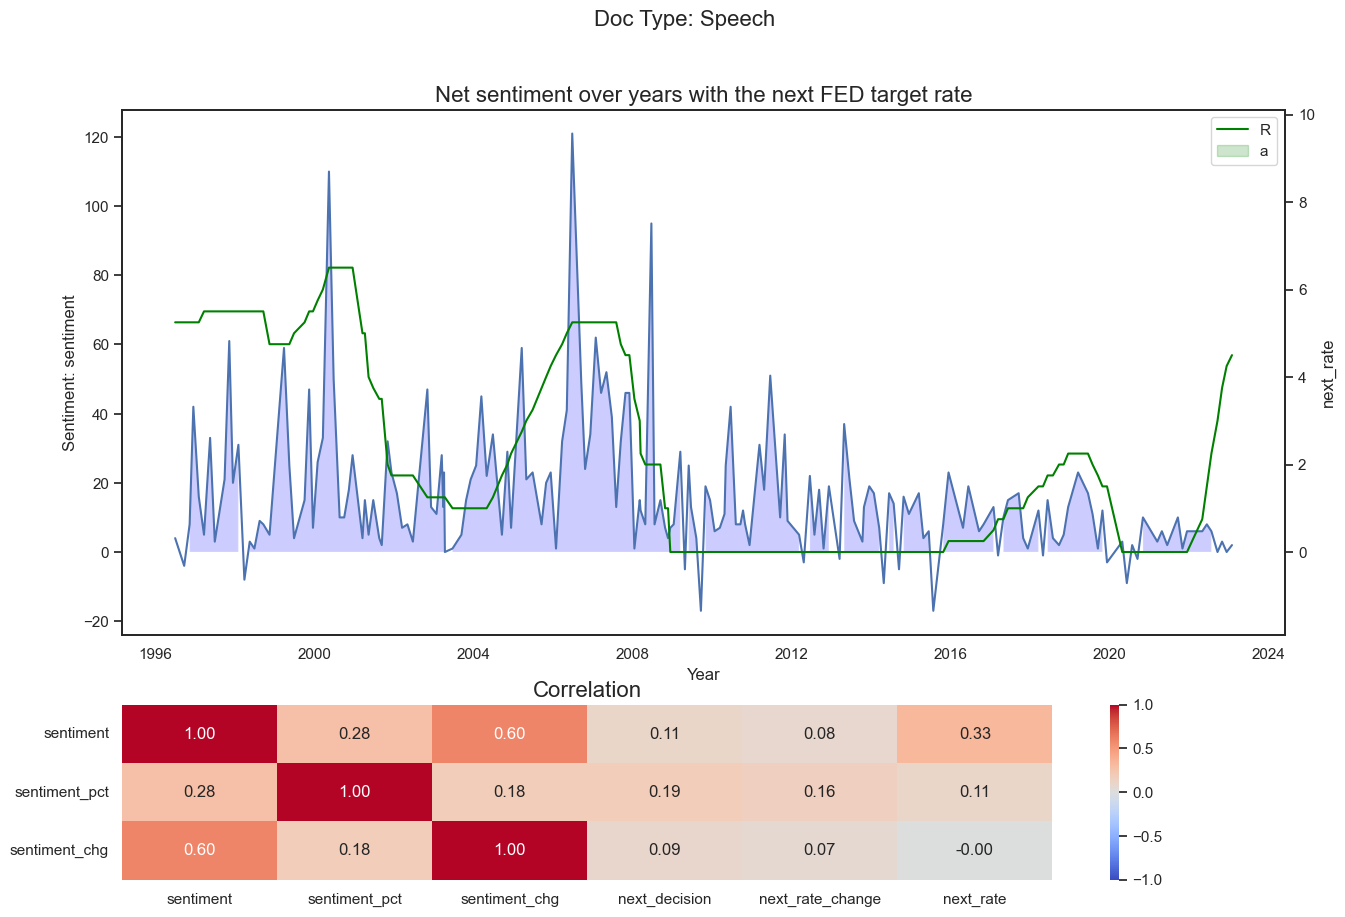

In [47]:
plot_sentiment(speech_df, 'Speech', 'sentiment')

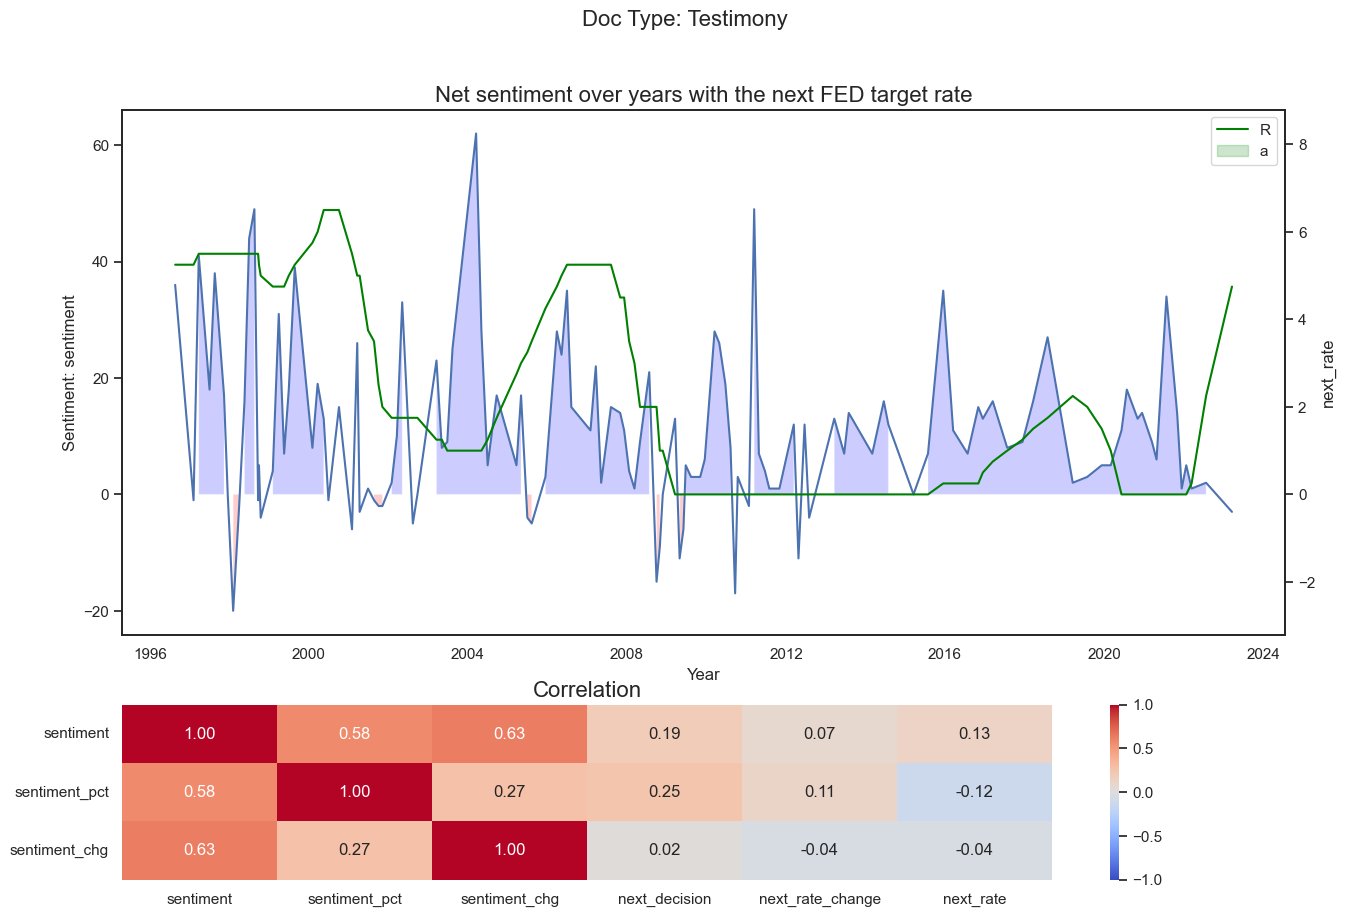

In [48]:
plot_sentiment(testimony_df, 'Testimony', 'sentiment')

Looking at the result, it seems Sentiment and Minutes have a certain correlation with FED Rate up and down, whereas Speech has little to do with it.

## Save Data

In [49]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [50]:
# Save text data
save_data(result_df, 'sentiment_bert_result')
save_data(all_df, 'sentiment_bert_all')
save_data(stmt_df, 'sentiment_bert_stmt')
save_data(minutes_df, 'sentiment_bert_minutes')
save_data(presconf_df, 'sentiment_bert_presconf')
save_data(m_script_df, 'sentiment_bert_m_script')
save_data(speech_df, 'sentiment_bert_speech')
save_data(testimony_df, 'sentiment_bert_testimony')

## Model and Train

In [75]:
# Load data
file = open(train_dir + 'train_df.pickle', 'rb')
train_df = pickle.load(file)
file.close()
print(train_df.shape)

(271, 32)


In [76]:
train_df.drop(columns=['statement', 'minutes', 'presconf_script', 'speech', 'testimony', 'text',
                      'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
                       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
                       'tfidf_Strong_Modal', 'tfidf_Constraining'], inplace=True)

#train_df.drop(columns=['tone','cos_sim_Negative',
#       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
#       'cos_sim_StrongModal', 'cos_sim_Constraining'], inplace=True)

In [77]:
# Use Statement Score and Minutes Score (Sentiment count, net score and change from the previous meeting) as inputs
train_df = train_df.merge(stmt_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left')
train_df = train_df.merge(minutes_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left', suffixes=('_stmt', '_minutes'))
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,...,Negative_stmt,Neutral_stmt,Positive_stmt,sentiment_stmt,sentiment_chg_stmt,Negative_minutes,Neutral_minutes,Positive_minutes,sentiment_minutes,sentiment_chg_minutes
date,,,,,,,,,,,,,,,,,,,,,
1993-02-18,1,1,1.042880,54.2,257.5,2.015140,0.000000,-0.015006,14.901418,0.030023,...,NaN,NaN,NaN,NaN,NaN,44.0,123.0,79.0,35.0,NaN
1993-05-18,1,1,0.166979,53.5,125.5,3.092456,0.066667,0.003106,13.455236,0.088803,...,NaN,NaN,NaN,NaN,NaN,42.0,76.0,59.0,17.0,-18.0
1993-07-07,1,1,0.166979,51.2,228.0,4.263357,0.000000,0.053298,13.446869,-0.036990,...,NaN,NaN,NaN,NaN,NaN,42.0,67.0,47.0,5.0,-12.0
1993-08-17,1,1,0.582113,49.6,245.0,4.611673,0.066667,0.004418,11.927296,0.011994,...,NaN,NaN,NaN,NaN,NaN,41.0,97.0,70.0,29.0,24.0
1993-09-21,1,1,0.582113,50.2,229.0,4.894733,0.100000,-0.004671,10.302509,-0.025253,...,NaN,NaN,NaN,NaN,NaN,35.0,62.0,55.0,20.0,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,2,2,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218,...,1.0,6.0,2.0,1.0,0.0,59.0,95.0,83.0,24.0,-14.0
2023-02-01,2,2,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248,...,1.0,6.0,2.0,1.0,0.0,78.0,87.0,63.0,-15.0,-39.0
2023-03-22,2,2,0.637398,47.4,360.0,0.156065,0.000000,0.359631,-19.636462,-0.224769,...,1.0,6.0,2.0,1.0,0.0,67.0,106.0,72.0,5.0,20.0


In [79]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'tone',
       'cos_sim_Negative', 'cos_sim_Uncertainty', 'cos_sim_Constraining',
       'cos_sim_Positive', 'cos_sim_Litigious', 'cos_sim_Strong_Modal',
       'Negative_stmt', 'Neutral_stmt', 'Positive_stmt', 'sentiment_stmt',
       'sentiment_chg_stmt', 'Negative_minutes', 'Neutral_minutes',
       'Positive_minutes', 'sentiment_minutes', 'sentiment_chg_minutes'],
      dtype='object')

In [54]:
from sklearn.metrics import accuracy_score, f1_score,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

import scikitplot as skplt

In [55]:
# Check the imputation
data = train_df.values
Xtmp, y1 = np.array(data[:, 1:], dtype=np.float64), np.array(data[:, 0], dtype=np.int64)+1
print('The number of training data: %d' % len(Xtmp))
print('Missing: %d' % sum(np.isnan(Xtmp).flatten()))
imputer = SimpleImputer(strategy='mean')
imputer.fit(Xtmp)
X1 = imputer.transform(Xtmp)
print('\nImputed:')
print('The number of training data: %d' % len(X1))
print('Missing: %d' % sum(np.isnan(X1).flatten()))

data2 = train_df.dropna().values
X2, y2 = np.array(data2[:, 1:], dtype=np.float64), np.array(data2[:, 0], dtype=np.int64)+1
print('\nDropped:')
print('The number of training data: %d' % len(X2))
print('Missing: %d' % sum(np.isnan(X2).flatten()))

The number of training data: 271
Missing: 392

Imputed:
The number of training data: 271
Missing: 0

Dropped:
The number of training data: 203
Missing: 0


In [56]:
# Check the pipeline with imputation
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Random Forest
scores = cross_val_score(pipeline, Xtmp, y1, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
scores = cross_val_score(pipeline, Xtmp, y1, scoring='f1_macro', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.761 (0.071)
Mean Accuracy: 0.607 (0.126)


In [57]:
random_state = 42
#kfold = StratifiedKFold(n_splits=10, random_state=random_state)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
imputer = SimpleImputer(strategy='mean')
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X1, y1, scoring=["accuracy", "f1_macro"], cv=kfold, n_jobs=-1))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std}).sort_values(by='CVAccMeans', ascending=False)

cv_res

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
4,ExtraTrees,0.757496,0.082337,0.605740,0.136986
3,RandomForest,0.756393,0.076954,0.596778,0.127248
5,GradientBoosting,0.746473,0.089126,0.620101,0.134573
9,LinearDiscriminantAnalysis,0.712037,0.064160,0.546906,0.118117
0,SVC,0.675265,0.014649,0.268689,0.003440
6,MultipleLayerPerceptron,0.670370,0.067294,0.505242,0.091314
8,LogisticRegression,0.651764,0.066406,0.386073,0.107521
1,DecisionTree,0.644400,0.077538,0.532844,0.102613
2,AdaBoost,0.643122,0.094328,0.531240,0.101686
7,KNeighboors,0.580644,0.079115,0.378465,0.092387


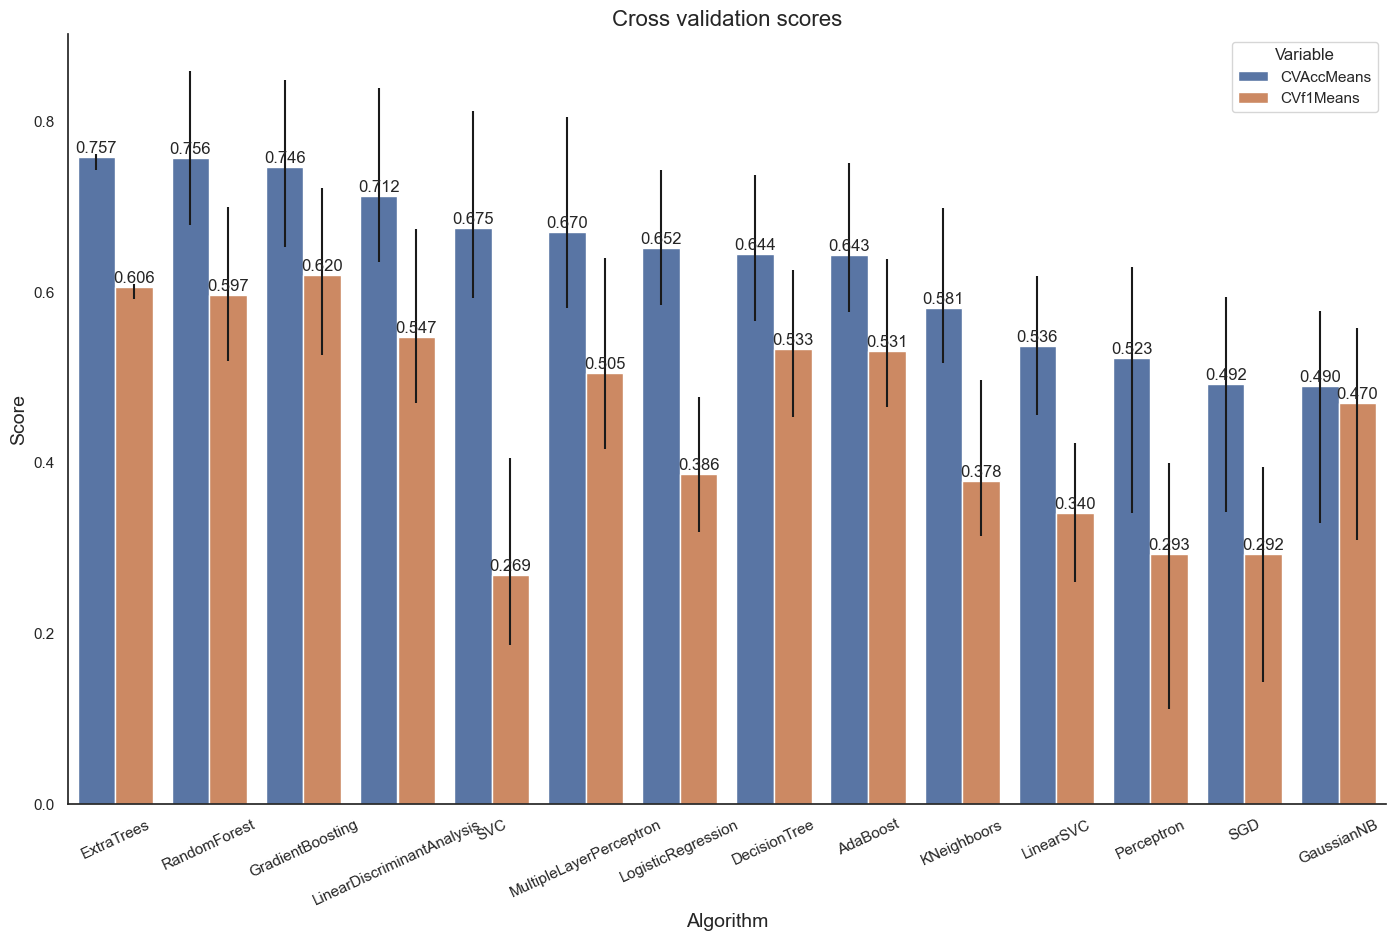

In [58]:

fig, ax = plt.subplots(figsize=(17,10))
tidy = cv_res[['Algorithm', 'CVAccMeans', 'CVf1Means']].melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax, **{'yerr':[cv_acc_std, cv_f1_std]})
sns.despine(fig)
ax.set_xlabel("Algorithm", size=14)
ax.set_ylabel("Score", size=14)
ax.legend(['Accuracy', 'F1 Score'])
ax.set_title("Cross validation scores", size=16)
for item in ax.get_xticklabels():
    item.set_rotation(25)



# Adding values on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.005, f'{height:.3f}', ha="center")


In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt



def plot_confusion_matrix_disp(estimator, X, y, display_labels, cmap, ax, normalize=None):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=cmap, ax=ax)

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))

        # ... (rest of the code)

        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)

        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)

        plot_confusion_matrix_disp(best_estimator, X_train, Y_train, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)

        plot_confusion_matrix_disp(best_estimator, X_train, Y_train, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax2, normalize='all')
        ax2.set_title("Train Data: Normalized")
        ax2.grid(False)

        plot_confusion_matrix_disp(best_estimator, X_test, Y_test, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax3)
        ax3.set_title("Test Data: Actual Count")
        ax3.grid(False)

        plot_confusion_matrix_disp(best_estimator, X_test, Y_test, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax4, normalize='all')
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)

        plt.tight_layout(pad=3.0)
        plt.show()

    return model



In [60]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [61]:
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X1, y1, test_size=0.2, shuffle=True)

Fitting 30 folds for each of 20 candidates, totalling 600 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_para

Best Score:  0.48554141491516345
Best Param:  {'algorithm': 'SAMME', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.0001, 'n_estimators': 1}


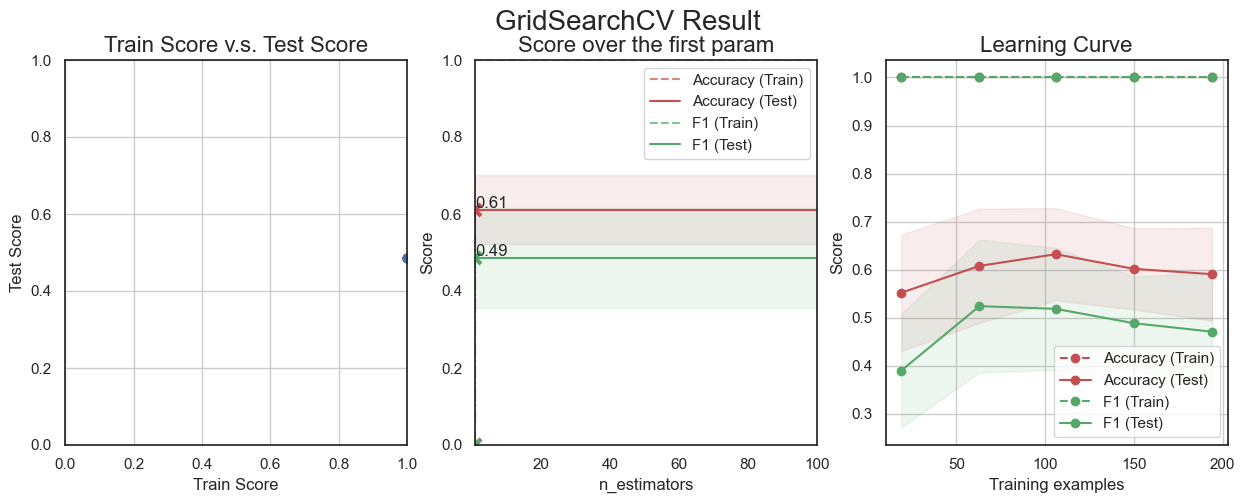

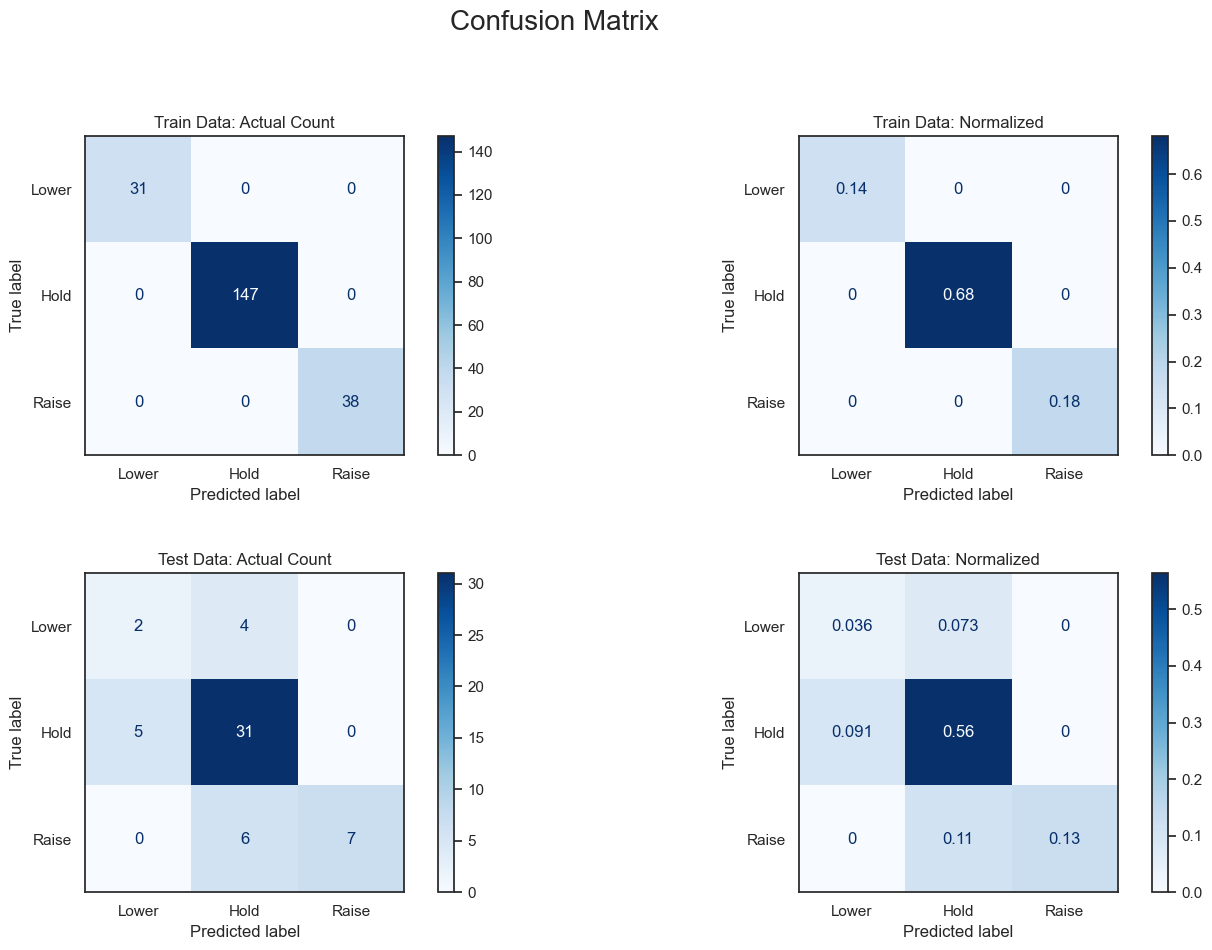

In [62]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

#Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 100, 20, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME'],
              'learning_rate': [0.0001]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[2023-07-31 16:49:29,396][INFO] ## Training - acc: 0.72222222, f1: 0.56724673
[2023-07-31 16:49:29,397][INFO] ## Test - acc: 0.72727273, f1: 0.58037687


Best Score:  0.45816820856527285
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1}


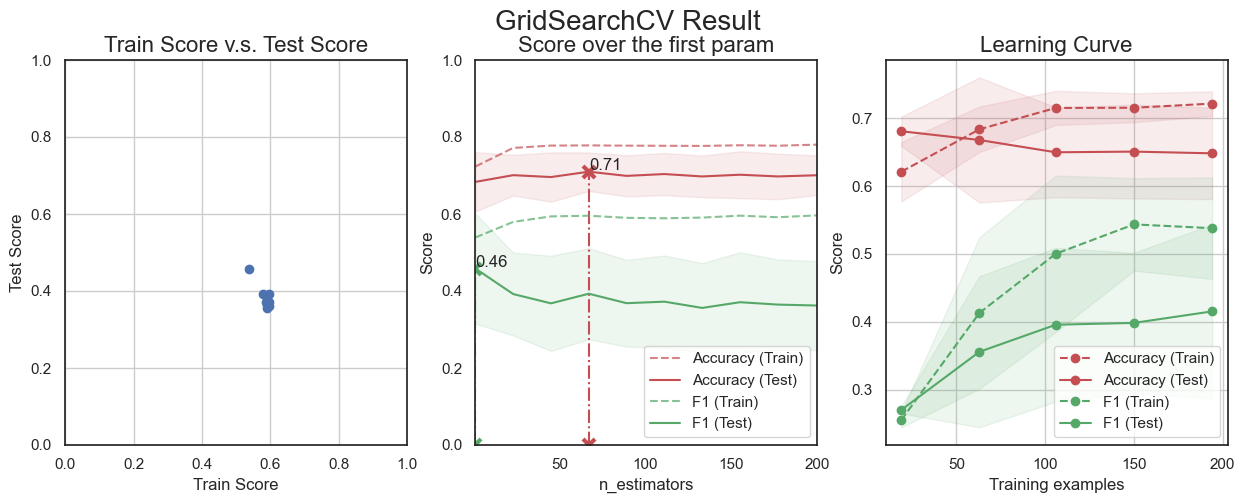

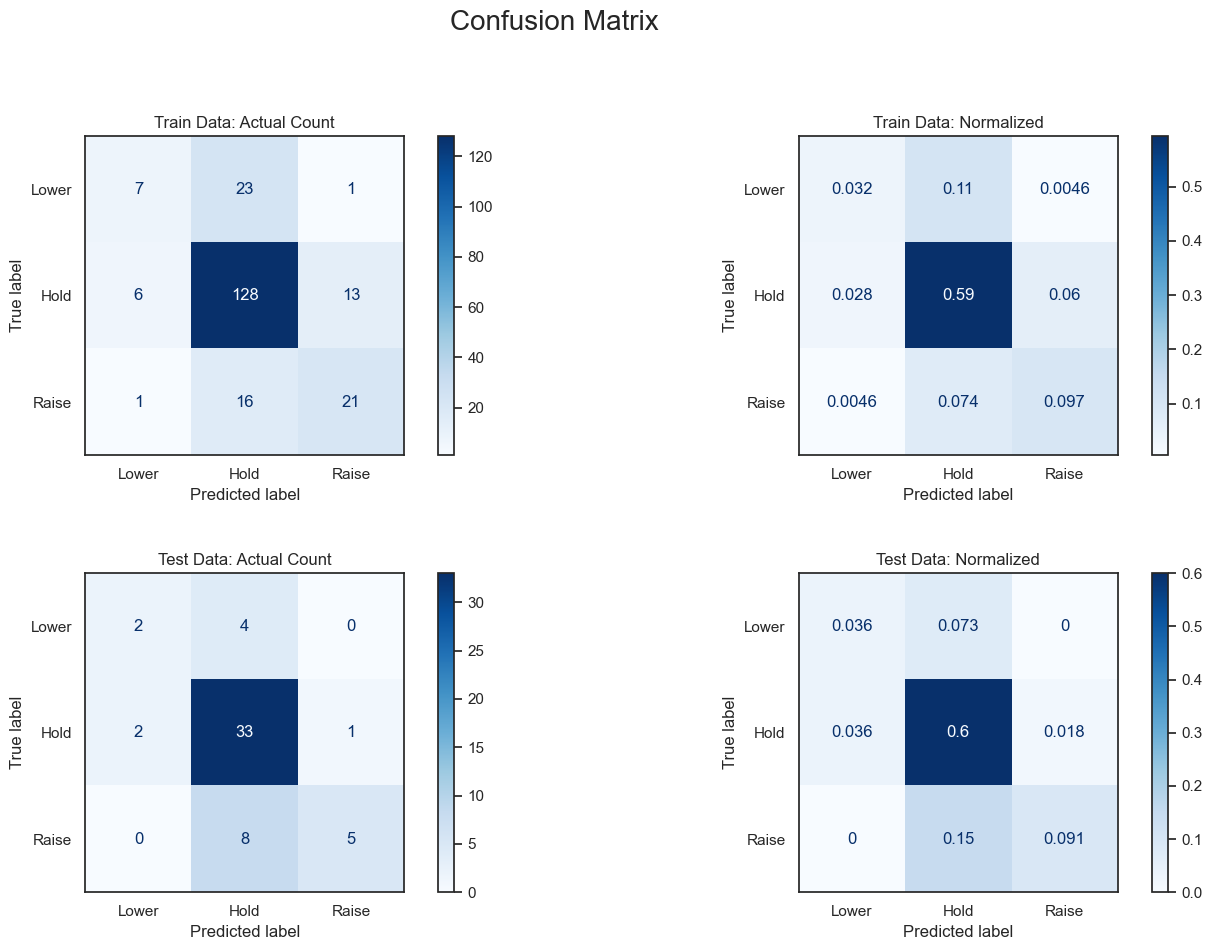

In [63]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)
#ExtraTrees 
ext_clf = ExtraTreesClassifier()
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 200, 10, dtype=int),
              'min_samples_split': [4],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[2023-07-31 16:49:41,037][INFO] ## Training - acc: 0.90277778, f1: 0.85537730
[2023-07-31 16:49:41,039][INFO] ## Test - acc: 0.74545455, f1: 0.63225678


Best Score:  0.5545993230311865
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 167}


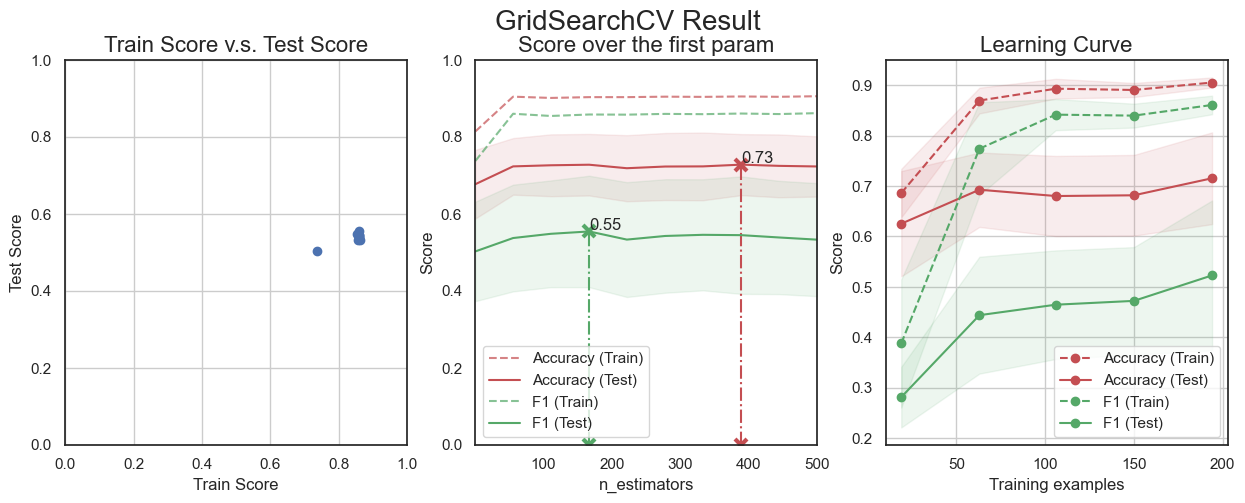

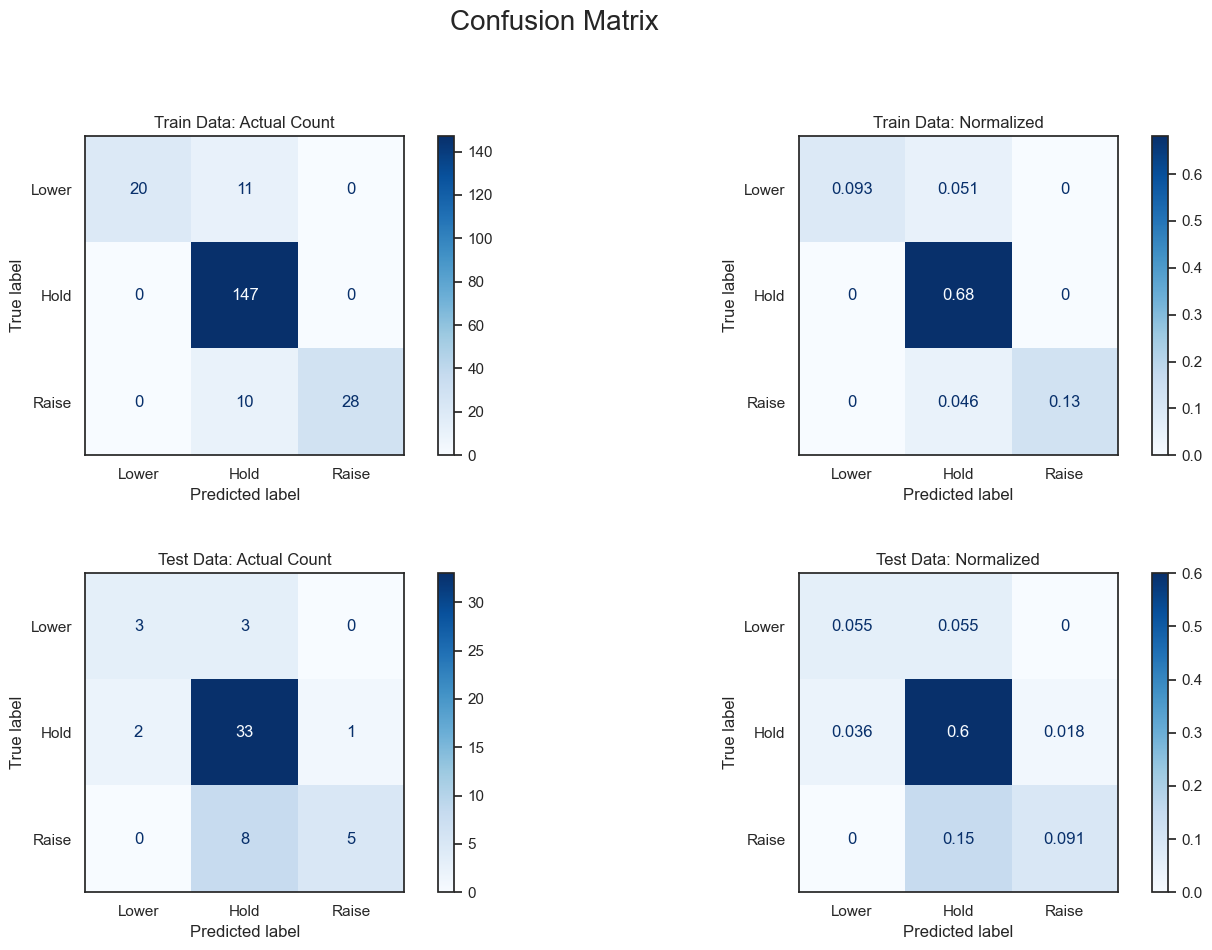

In [64]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 10, dtype=int),
              'min_samples_split': [8],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Fitting 30 folds for each of 8 candidates, totalling 240 fits


[2023-07-31 16:50:04,326][INFO] ## Training - acc: 1.00000000, f1: 1.00000000
[2023-07-31 16:50:04,328][INFO] ## Test - acc: 0.70909091, f1: 0.60550561


Best Score:  0.5952179830083566
Best Param:  {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.8, 'min_samples_leaf': 16, 'n_estimators': 400}


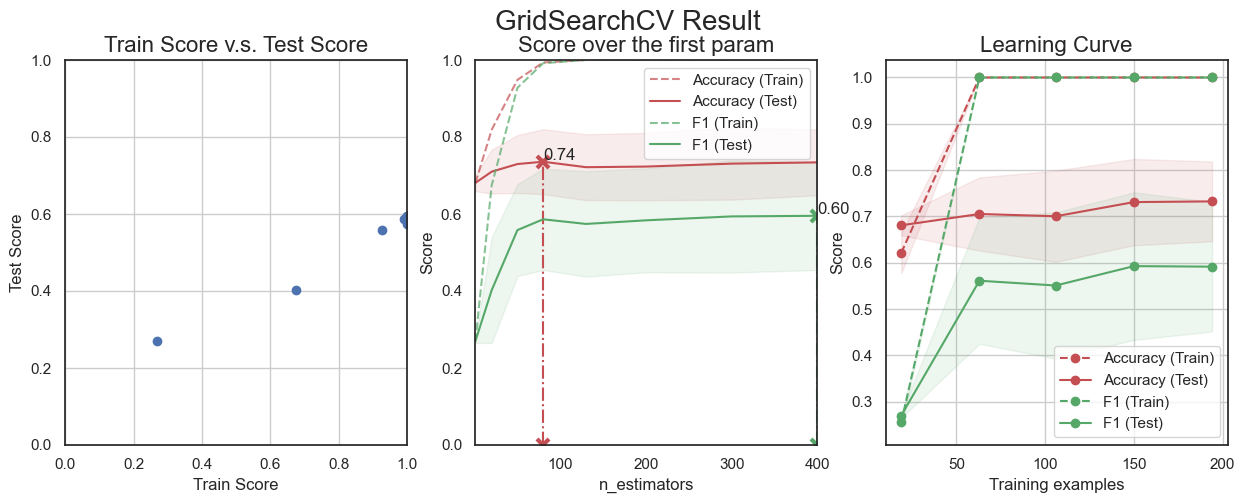

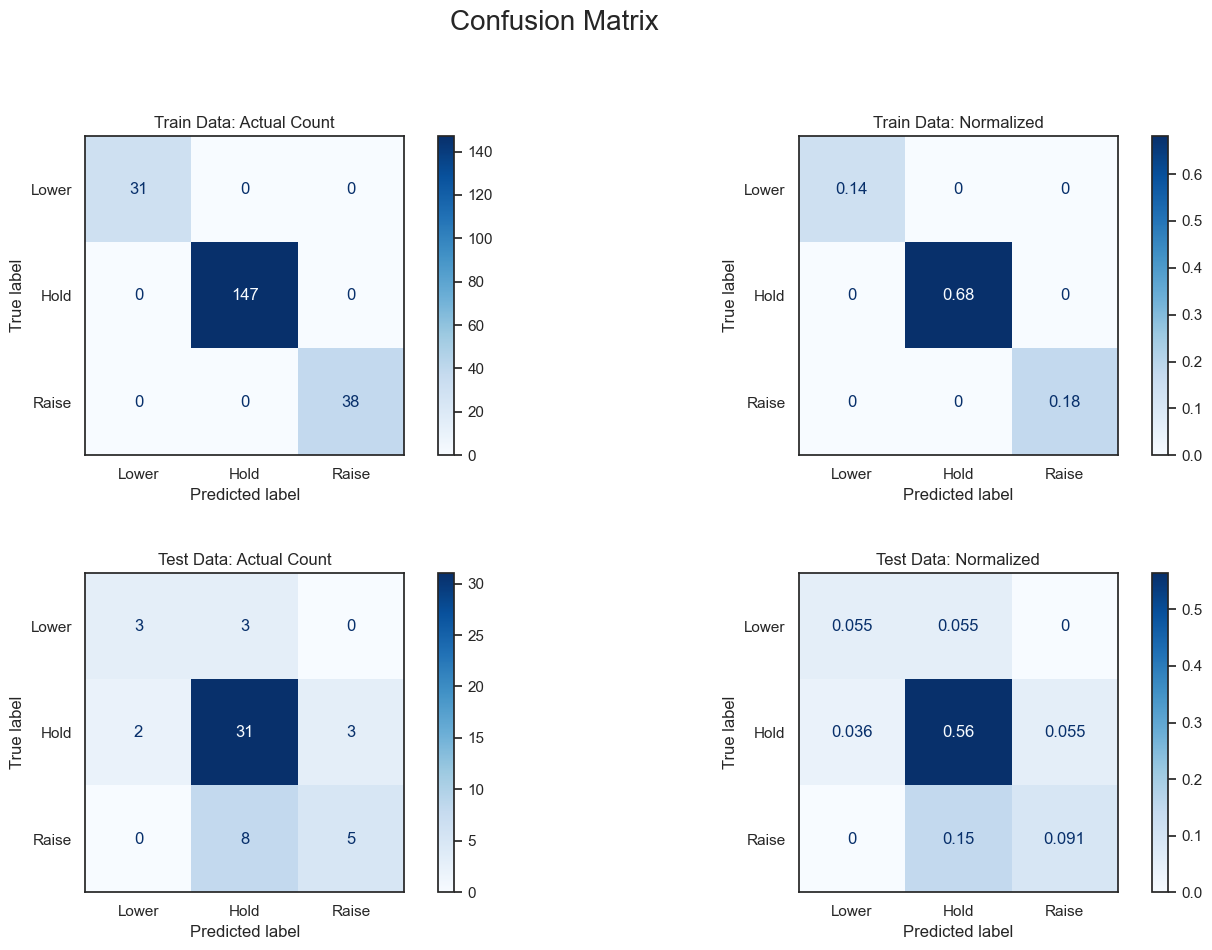

In [65]:
# Gradient boosting
gb_clf = GradientBoostingClassifier(random_state=2)

# Perform Grid Search
param_grid = {
    'n_estimators': [1, 20, 50, 80, 130, 200, 300, 400],
    'min_samples_leaf': [16],
    'max_features': [0.8],
    'max_depth': [4],
    'learning_rate': [0.05]
}

gb_model = train_grid_search(gb_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
gb_best = gb_model.best_estimator_


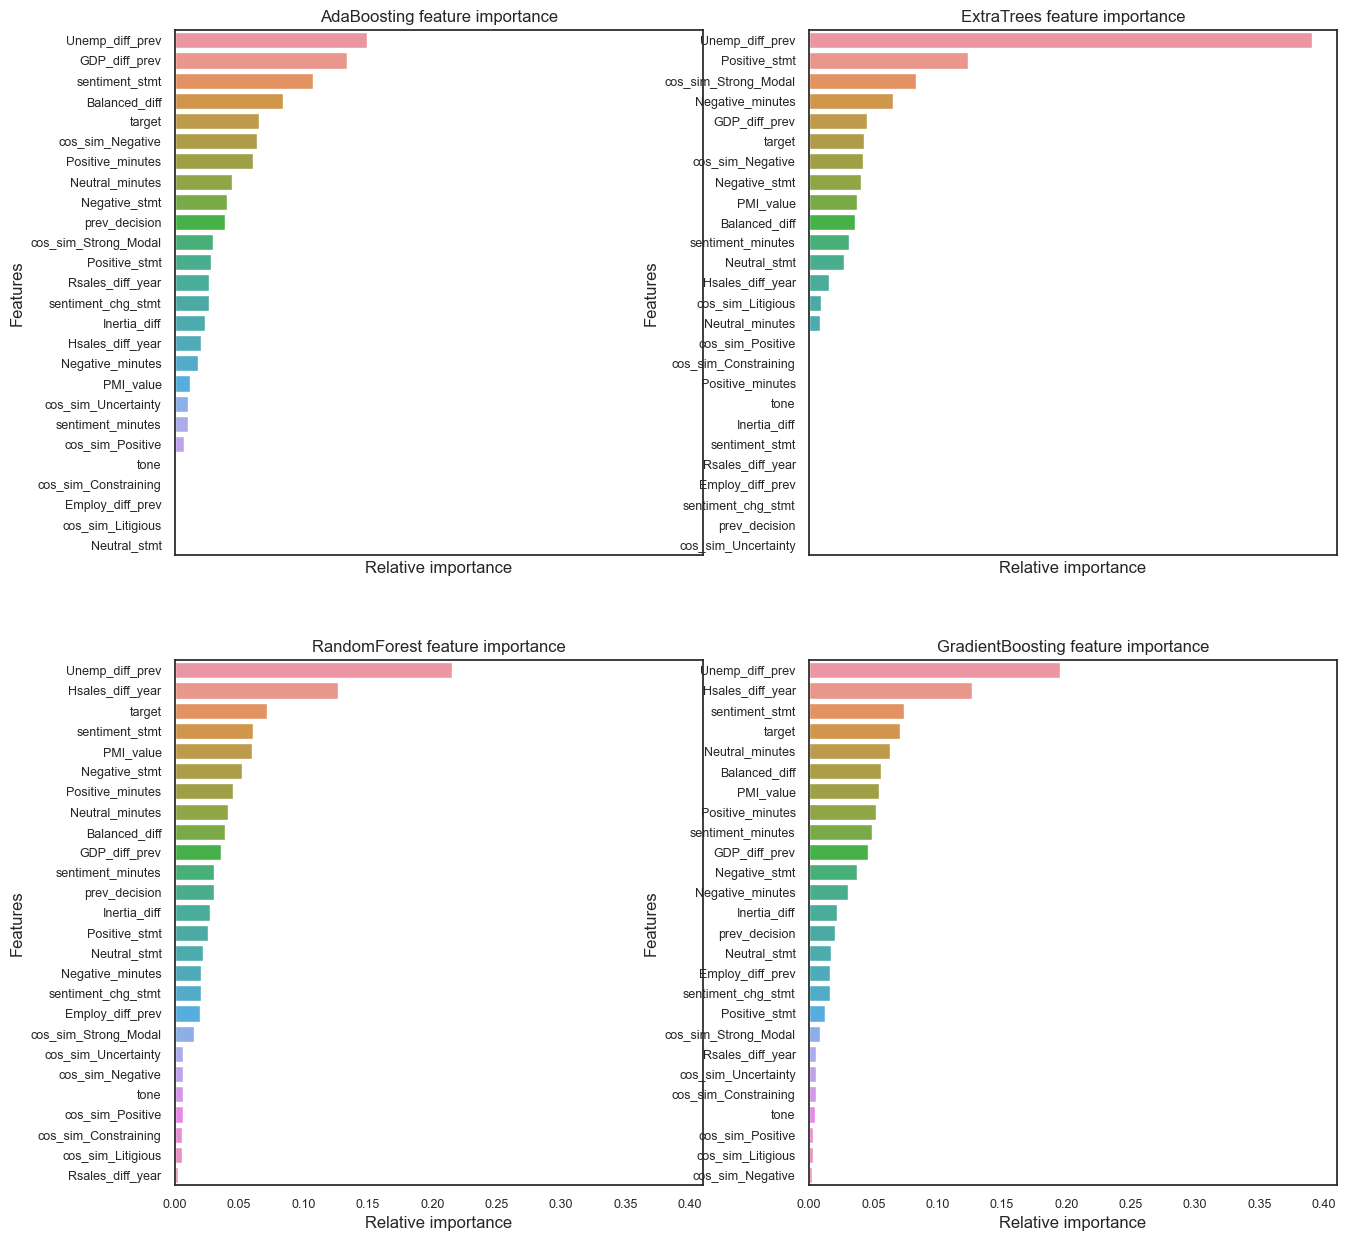

In [66]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

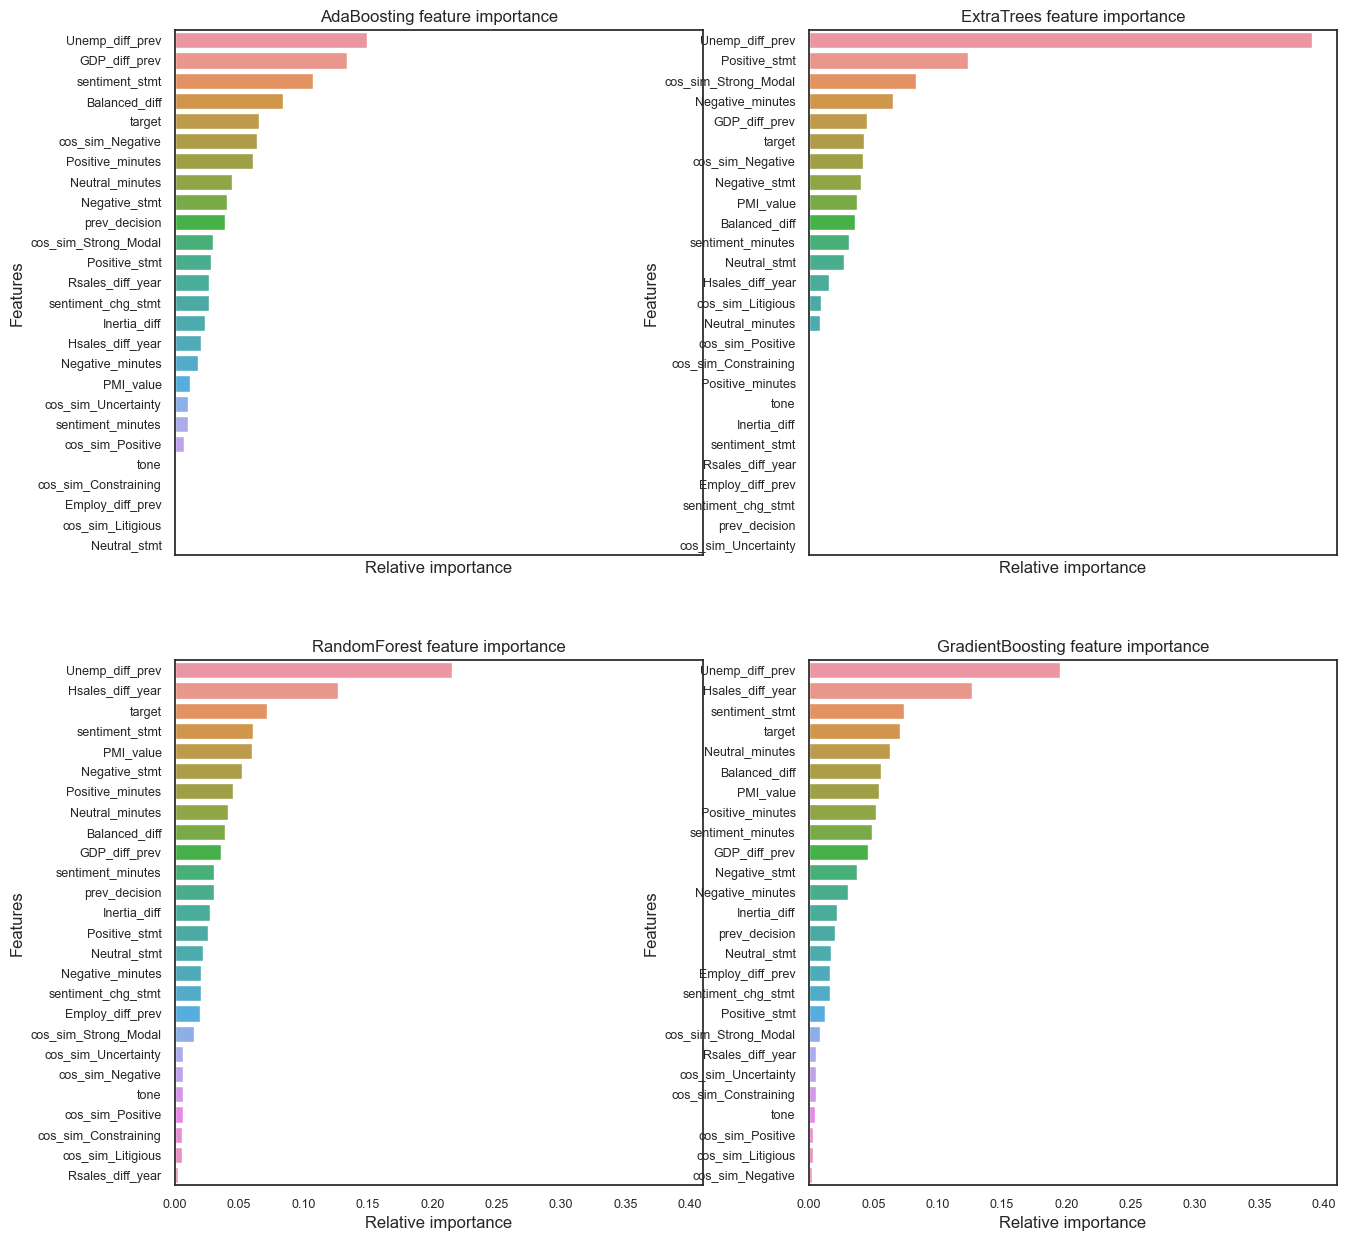

In [67]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1


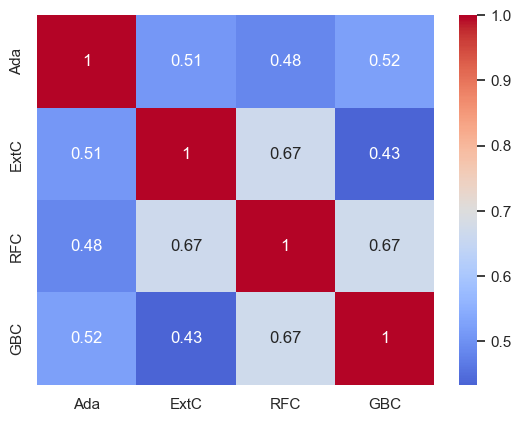

In [68]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

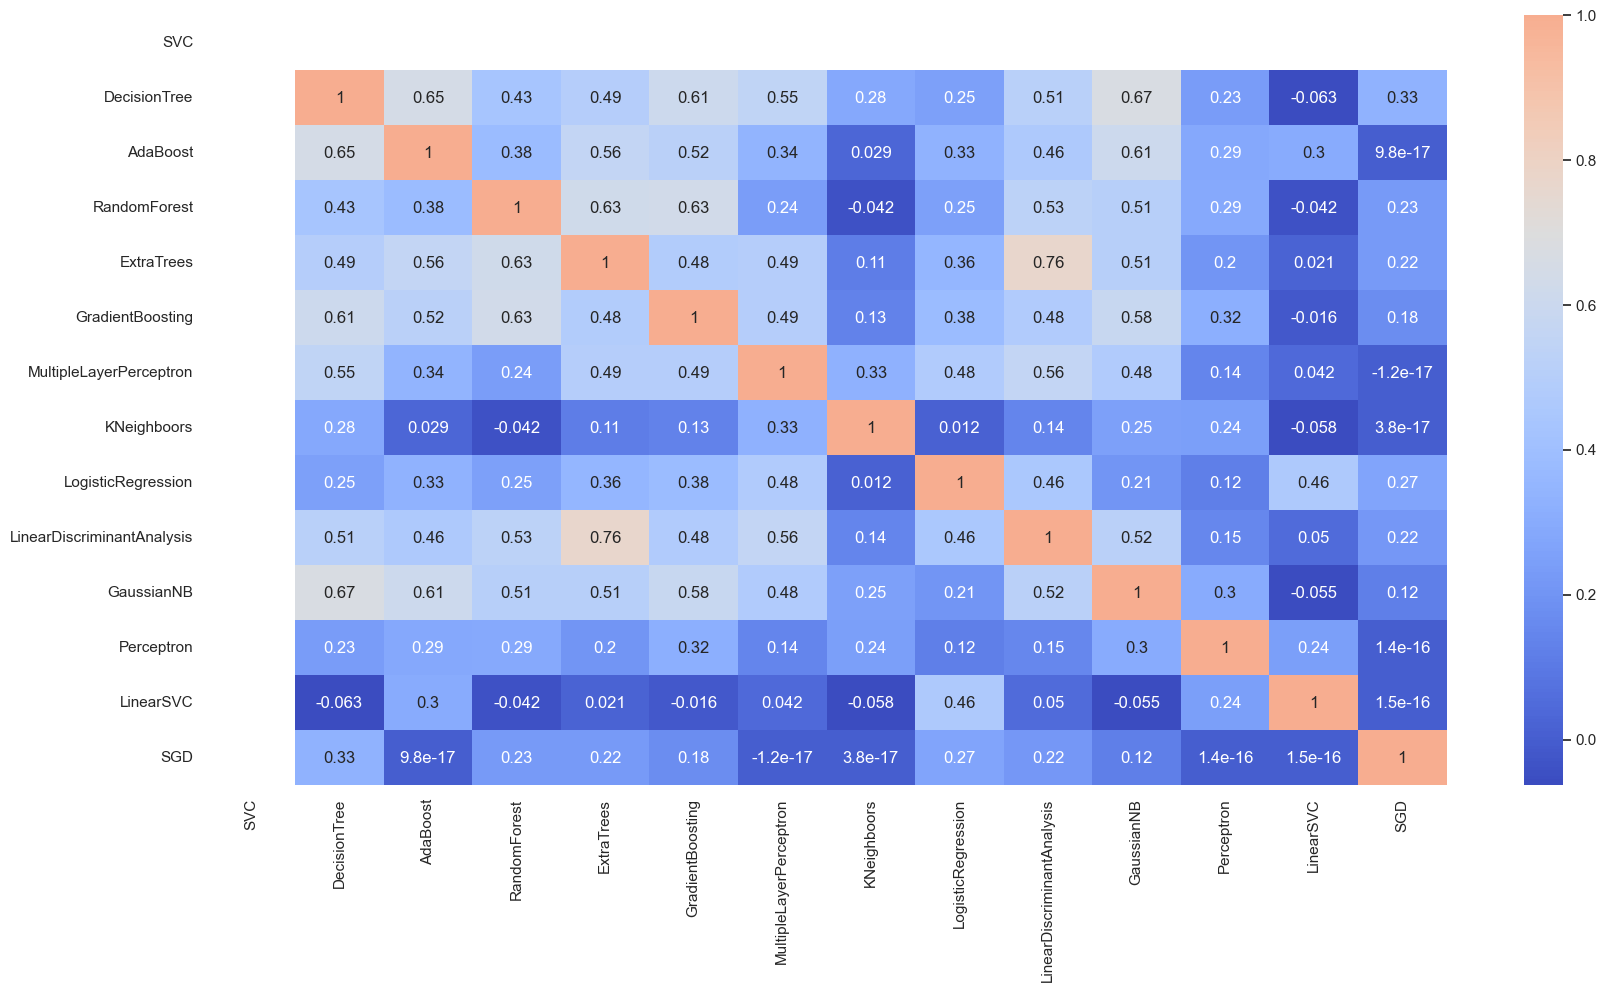

In [69]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

In [70]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best)], voting='soft', n_jobs=-1)

# # Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best.fit(X_train, Y_train)

VotingClassifier(estimators=[('adac',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 estimator=DecisionTreeClassifier(splitter='random'),
                                                 learning_rate=0.0001,
                                                 n_estimators=1,
                                                 random_state=42)),
                             ('extc',
                              ExtraTreesClassifier(max_features=8,
                                                   min_samples_leaf=8,
                                                   min_samples_split=4,
                                                   n_estimators=1)),
                             ('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=8,
                                                     min_samples_leaf=8,
                                                     min_samples_split=8,
                                                     n_estimators=167)),
                             ('gbc',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         max_features=0.8,
                                                         min_samples_leaf=16,
                                                         n_estimators=400,
                                                         random_state=2))],
                 n_jobs=-1, voting='soft')

In [71]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2023-07-31 16:50:46,290][INFO] ## Train - acc: 1.00000000, f1: 1.00000000
[2023-07-31 16:50:46,291][INFO] ## Test - acc: 0.74545455, f1: 0.64166667
